# STI vs CSIM Post-Processing

## This tool was created by RRD Engineering, LLC for the benefit of Makani Technologies, LLC 

## ** If parts of this tool are used elsewhere and/or in publications, please acknowledge the authors and this contribution **¶

#### ~/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/

#### ~/makani/logs   

In [1]:
import pandas as pd
from pathlib import Path
import os, sys, datetime
import numpy as np
import h5py
import pylab
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from myrotation import myRotation 
import seaborn as sns
sns.set(style="darkgrid")
import socket
injupyter=hasattr(__builtins__,'__IPYTHON__') #whether or not in jupyter
# from IPython.core.debugger import set_trace  #uncomment here for debugger

## INPUTS

In [2]:
#This is for INPUTS
# main files
kfastOfile='KiteFast.out'
csimOfile='last.h5'#'last_z2.h5' for lowstart #'last.h5'for high
csimTstart=487. # 480.for low start #487. for high  #seconds from which to start extracting data in the original h5

#pick one of these
#kfastTestCase='RRD_m600_landbased'  #The name of the folder containing the kfast test input/output files
kfastTestCase='RRD_m600_land_hiStart'  #The name of the folder containing the kfast test input/output files
#kfastTestCase='RRD_m600_land_hiStart_free'  #The name of the folder containing the kfast test input/output files
#kfastTestCase='RRD_m600_landbased_free'  #The name of the folder containing the kfast test input/output files

posfile='csim2kfast_pos.txt'
# pick general path for KFAST test dir  (starts at sandbox) (This should not change)
ktestdir=Path('sandbox/glue-codes/kitefast/test_cases/')

#moordyn file to extract anchor point with path from ktestdir
md_ifile=Path(kfastTestCase,'m600-MoorDyn.dat')
#KiteAerodyn file to extract density with path from ktestdir
ad_ifile=Path('kiteaerodyn','m600_model.inp')
#KiteFASTController output file to extract gentorques and possibly other variables
kfc_ofile=Path('KFCdriver_test.KFC.out')
#A file that gathers CSIM values that simulate outputs of the controller to be read in by KiteFAST>>> it gets written here
ctrl_ofile=Path('RRD_ctrl.outs')
#The STI ctrl output file
STI_ofile=Path('controller_save_data.csv')
#A file that can be used to test STI controller in standalone mode, containing states as given by CSIM
STI_ifile=Path('CSIMstates.inp')

# pick whether kitefast.out will be from ROTOR's run (True) or kitefast (False) (regardless of PC used to post-process)
use_RotorKFAST=False

# The following should not change
#KiteFAST
#homedir=os.path.expanduser('~') #this should work on linux, on my windows I have rickdami (superuser and not rdamiani which messes up ~)
homedir_rotor=Path('D:\\RRD_ENGINEERING','PROJECTS\\','WE201904_Makani\\')
homedir_linux=Path('/home/rdamiani/') #For laptop "kitefast" use this one, else comment out

#kitefast mount point for ROTOR share

k_rotorshare=""

#CSIM
ctestdir_rotor=Path('Z/\\192.168.0.27\makani_csim','logs') #from ROTOR
ctestdir_linux=Path(os.path.expanduser('~'),'makani','logs')   #from kitefast laptop, else comment out

#DCM from CSIM global to KFAST global; 
# i.e. colum vectors of \hat(xg_c),\hat(yg_c),\hat(zg_c) in KFAST global^
dcm_cg2fg= np.array([[-1.,0,0],\
            [0,1.,0],\
            [0,0,-1.]]).T
#print(ctestdir)

#os.getcwd()
#os.chdir(os.path.expanduser('~')
nmotors=8

In [3]:
#    theNotebook=__file__
theNotebook='STIvsCSIM'

## Note the variables we are interested in comparing between CSIM and STI are those output by the controller

vars considered: 
flaps, motor speeds, genTorq(*)         

In [4]:
#Auxiliary to get the correct paths
currenthost=socket.gethostname()
if currenthost=='kitefast':
    homedir=homedir_linux
    if use_RotorKFAST:
        ktestcasedir=Path(homedir,k_rotorshare,ktestdir,kfastTestCase)
    else:
        ktestcasedir=Path(homedir,ktestdir,kfastTestCase)
    path2cfile=Path(ctestdir_linux,csimOfile)
    #add path if in case I want to use makani scripts
    sys.path += ['/home/rdamiani/','home/rdamiani/makani/analysis/plot/python/plot_groups/']
else:  #we are on ROTOR
    homedir=homedir_rotor
    ktestcasedir=Path(homedir,ktestdir,kfastTestCase)
    path2cfile=Path(ctestdir_rotor,csimOfile)

path2kfile=Path(ktestcasedir,kfastOfile)
path2mdfile=Path(homedir,ktestdir,md_ifile) 
path2kadfile=Path(homedir,ktestdir,ad_ifile) 
path2posfile=Path(homedir,ktestcasedir,posfile) 
path2kfcfile=Path(homedir,ktestcasedir,kfc_ofile)
path2CtrlOuts=Path(homedir,ktestcasedir,ctrl_ofile)
path2STIOuts=Path(homedir,ktestcasedir,STI_ofile)
path2STIInps=Path(homedir,ktestcasedir,STI_ifile)
path2kfcfile,path2mdfile,path2kadfile,path2CtrlOuts,path2STIOuts,path2STIInps

(PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/KFCdriver_test.KFC.out'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/m600-MoorDyn.dat'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/kiteaerodyn/m600_model.inp'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/RRD_ctrl.outs'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/controller_save_data.csv'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/CSIMstates.inp'))

In [5]:
# Auxiliary
coords=['x','y','z']
ncoords=len(coords) #number of coordinates
colors=['red','green','blue']
attstr=['roll','pitch','yaw']

## Start  by Loading CSIM & browse content to extract what we need. 

In [6]:
log = h5py.File(path2cfile, 'r')
list(log.keys())
#We will take messages per https://docs.google.com/document/d/1kObFA1sbUa-6svxoL4RQl615Qhe8sGzvkGuvsEAwD8o/edit?ts=5dd4417d#

['bad_packets', 'info', 'messages', 'parameters']

In [7]:
pitot_xyz=log['parameters']['system_params']['pitot']['pos'][0]
pitot_xyz
print(('pitot coords ='+3*'{:5.3f} ').format(*pitot_xyz))

pitot coords =3.213 0.000 0.443 


In [8]:
log['parameters']['system_params']['pitot']['dcm_b2p']

array([([[ 0.99862953,  0.        ,  0.05233596], [ 0.        ,  1.        ,  0.        ], [-0.05233596,  0.        ,  0.99862953]],)],
      dtype=[('d', ('<f8', (3,)), (3,))])

In [9]:
print(np.rad2deg(log['parameters']['system_params']['pitot']['port_angle']))
log['parameters']['system_params']['pitot'].dtype

[26.92901637]


dtype([('pos', [('x', '<f8'), ('y', '<f8'), ('z', '<f8')]), ('dcm_b2p', [('d', ('<f8', (3,)), (3,))]), ('port_angle', '<f8'), ('sensors', [('max_pressure', '<f8'), ('stat_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24}), ('alpha_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24}), ('beta_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24}), ('dyn_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24})], (2,)), ('local_pressure_coeff', '<f8')])

In [10]:
tetherdata=log['parameters']['system_params']['tether']

In [11]:
tetherdata['length']

array([425.8])

In [12]:
shaft_axis_c=np.vstack([log['parameters']['system_params']['rotors']['axis']['x'], \
     log['parameters']['system_params']['rotors']['axis']['y'], \
     log['parameters']['system_params']['rotors']['axis']['z']]).transpose()

shaft_tilt_c=np.arccos(shaft_axis_c[:,0])
print(('shaft tilt = '+nmotors*'{:5.3f} deg  ').format(*np.rad2deg(shaft_tilt_c)))
shaft_axis_c.shape
shaft_axis_c.tolist()
('shaft axis components w.r.t. body ref = ' + 3*'{:12.10f},' +';\n   ')
print(('shaft axis components w.r.t. body ref = ' + nmotors*('[' +ncoords* '{:12.10f}, ' +'];\n')).format(*shaft_axis_c.flatten()))

shaft tilt = 3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  
shaft axis components w.r.t. body ref = [0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];



In [13]:
rho_c=log['parameters']['sim_params']['phys_sim']['air_density']
print('CSIM air density is=', rho_c)

CSIM air density is= [1.026]


In [14]:
log['messages']['kAioNodeControllerA'].keys()  #to get this main NodeController which has the data of interest, but i think it is the estimator 

<KeysViewHDF5 ['kMessageTypeControlDebug', 'kMessageTypeControlSlowTelemetry', 'kMessageTypeControlTelemetry', 'kMessageTypeControllerCommand', 'kMessageTypeControllerSync', 'kMessageTypeQ7SlowStatus', 'kMessageTypeSimCommand', 'kMessageTypeSmallControlTelemetry']>

In [15]:
tel=log['messages']['kAioNodeSimulator']['kMessageTypeSimTelemetry']['message']
tel['tether']['Xg_end'],tel['rotors']['local_apparent_wind_b']['x'].shape

(array([(-417.12782571,   23.1191995 , -107.7233635 ),
        (-416.93842345,   24.11150628, -108.20777171),
        (-416.74485732,   25.09787636, -108.69745171), ...,
        (-315.47401982, -139.19485509, -256.91841202),
        (-315.92389782, -139.69977878, -256.10314245),
        (-316.37744565, -140.1982095 , -255.28258456)],
       dtype=[('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), (2351, 8))

In [16]:
# SO the dataset of interest for us is under 'wing'; 
# as it will have those vars declared at the top of this notebook
csim_dset=tel['wing']

In [17]:
#In case I need to go back to estimator:
tel2=log['messages']['kAioNodeControllerA']['kMessageTypeControlTelemetry']['message']
tel3=log['messages']['kAioNodeControllerA']['kMessageTypeControlDebug']['message']
tel2
# and the dataset of interest for us is under 'state_est'; 
csim_dset2=tel2['state_est']
tel2['time']
tel3['time'].shape
csim_dset2['acc_norm_f'].shape,tel3['state_est']['acc_norm_f'].shape

((471,), (4701,))

In [18]:
time_c=tel['time']
print(time_c[0], time_c[-1])
dt_c=time_c[1]-time_c[0]
dt_c

480.0 527.0


0.01999999999998181

## Find the index in the database that corresponds to csimTstart


In [19]:
tel_idx0=np.argmin(np.abs(time_c -csimTstart))
tel_idx0

print('this is where we start extracting the ''tel'' database {:d}'.format(tel_idx0))
print('length of array after removing the data before csimTstart {:d}'.format(len(time_c)-tel_idx0))


this is where we start extracting the tel database 350
length of array after removing the data before csimTstart 2001


## Find the index in the tel2 and tel3 database that corresponds to csimTstart

In [20]:
tel2_idx0=np.int(tel_idx0/5)

print('this is where we start extracting the ''tel2'' database {:d}'.format(tel2_idx0))
tel3_idx0=np.int(tel_idx0*2)
print('this is where we start extracting the ''tel3'' database {:d}'.format(tel3_idx0))

this is where we start extracting the tel2 database 70
this is where we start extracting the tel3 database 700


In [21]:
## Curtail the time_c
time_c=time_c[tel_idx0:]

In [22]:
# Adjust (reset time)
time_c2k=(time_c-time_c[0]).reshape([-1,1])

In [23]:
# Read Rotor , Generator Torque, Rotor Accelerations, Rotor Thrusts from dataset rotors
aero_torque_c=tel['rotors']['aero_torque'][tel_idx0:,:]

gen_torque_c=tel['rotors']['motor_torque'][tel_idx0:,:]
rot_accel_c=tel['rotors']['rotor_accel'][tel_idx0:,:]
rot_thrust_c=tel['rotors']['thrust'][tel_idx0:,:]

aero_torque_c.shape,gen_torque_c.shape, rot_accel_c.shape, rot_thrust_c.shape

((2001, 8), (2001, 8), (2001, 8), (2001, 8))

In [24]:
# Read rotor speeds (50 Hz=0.02s) also commanded rotor speeds (from tel2 they come at 10Hz=0.1s, so look below for 100Hz)
rot_speed_c=tel['rotor_sensor']['rotor_speeds'][tel_idx0:,:]
rot_speed_c.shape,rot_speed_c[0,:]

((2001, 8), array([-147.04030494,  144.95709162,  142.84756789, -140.69129891,
         164.78840932, -166.67006592, -168.51733421,  170.32359032]))

In [25]:
#cmds=tel2['control_output']  #This one is at 10Hz
cmds=log['messages']['kAioNodeControllerA']['kMessageTypeControlDebug']['message']['control_output'] #This is at 100 Hz
cmds.dtype

dtype([('sync', [('sequence', 'u1'), ('flight_mode', '>i4')]), ('flaps', '>f8', (8,)), ('motor_speed_upper_limit', '>f8', (8,)), ('motor_speed_lower_limit', '>f8', (8,)), ('motor_torque', '>f8', (8,)), ('winch_vel_cmd', '>f8'), ('detwist_cmd', '>f8'), ('stop_motors', '?'), ('run_motors', '?'), ('tether_release', '?'), ('gs_mode_request', '>i4'), ('gs_unpause_transform', '?'), ('gs_azi_cmd', [('target', '>f8'), ('dead_zone', '>f8')]), ('hold_gs_azi_cmd', '?')])

In [26]:
cmds_idx0=tel_idx0*2

In [27]:
cmd_rot_speed_c=cmds['motor_speed_upper_limit'][cmds_idx0:,:]
cmd_rot_speed_c.shape

(4001, 8)

In [28]:
# Read FlapSettings
flaps_c=tel['wing']['flaps'][tel_idx0:,:]
flaps_c.shape

(2001, 8)

In [29]:
nflaps=flaps_c.shape[1]

In [30]:
csim_dset['tether_force_b'].dtype

dtype([('tension', '>f8'), ('roll', '>f8'), ('pitch', '>f8')])

In [31]:
#Tether tension in N.

tether_force_b_c=csim_dset['tether_force_b']['tension'][tel_idx0:]
tether_force_b_c.size

2001

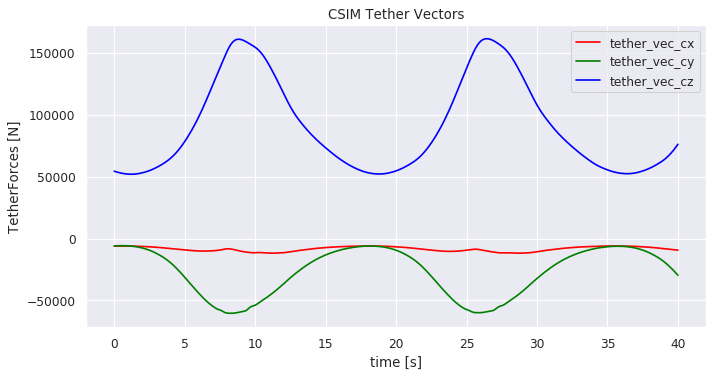

In [32]:
#Calculate vector components of that force to compare to KFAST
tether_vec_c=np.zeros([tether_force_b_c.size,3])
ph=csim_dset['tether_force_b']['roll'][tel_idx0:]
th=csim_dset['tether_force_b']['pitch'][tel_idx0:]
tether_vec_c[:,2]=tether_force_b_c*np.cos(ph)*np.cos(th)
tether_vec_c[:,1]=-tether_force_b_c*np.sin(ph)
tether_vec_c[:,0]=-tether_force_b_c*np.cos(ph)*np.sin(th)
tether_vec_c.shape
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k');
ax = fig.add_subplot(111)

for ii in range(0,3):
    ax.plot(time_c2k,tether_vec_c[:,ii], label='tether_vec_c'+coords[ii],color=colors[ii])
    #ax.plot(time_c[::5],Ag_c2[:,ii], label='estimator Ag_c2_',color=colors[ii],linestyle='--')
    
#ax.set_aspect('equal')
plt.xlabel('time [s]')
plt.ylabel('TetherForces [N]')
plt.title('CSIM Tether Vectors')
plt.legend(loc='best')
plt.show()

In [33]:
# CSIM Xg is from the slew bearing (NOT anchor point); so this should be ok in KFAST
Xg_c=csim_dset['Xg'][tel_idx0:]
#Xg_c2k are c data massaged for KiteFAST to ingest it in its global coordinate system
# so Rotate the data
Xg_c2k=np.array(Xg_c.tolist(),dtype='float')
Xg_c2k=np.matmul(dcm_cg2fg, Xg_c2k.transpose()  ).transpose()
Xg_c2k 

#start point to initialize KFAST
init_Xg_k=Xg_c2k[0,:]
print(('Xg[0] for KFAST .mbd and .set = '+ 3*' {:17.10f}').format(*init_Xg_k))
print(423.44-421.644)

Xg[0] for KFAST .mbd and .set =     299.6791918037     17.5337634440    313.7610198871
1.7959999999999923


In [34]:
Xg_c2k.shape

(2001, 3)

In [35]:
# CSIM Vg  (similarly to Xg); 
Vg_c=csim_dset['Vg'][tel_idx0:]
Vg_c2k=np.array(Vg_c.tolist(),dtype='float')
Vg_c2k=np.matmul(dcm_cg2fg, Vg_c2k.transpose()  ).transpose()
Vg_c2k 

#start point to initialize KFAST
init_Vg_k=Vg_c2k[0,:]
init_Vg_k
print( ('MIP RF initial vel = '+ 3*' {:17.10f}').format(*init_Vg_k) )
print( ('reference, global,  '+ 3*' {:17.10f},').format(*init_Vg_k) )

MIP RF initial vel =     -10.5183018943    -33.0589012385     11.8170092933
reference, global,      -10.5183018943,    -33.0589012385,     11.8170092933,


In [36]:
# CSIM Vb in body coordinates
Vb_c=csim_dset['Vb'][tel_idx0:]
Vb_c2k=np.array(Vb_c.tolist(),dtype='float')
Vb_c2k 

array([[35.25357658, -7.60818173, -6.51676637],
       [35.25746963, -7.63040963, -6.52218185],
       [35.26176147, -7.65257728, -6.52763386],
       ...,
       [51.75488924, -4.32748262, -9.89947824],
       [51.88863482, -4.25448711, -9.89044074],
       [52.02235184, -4.18132289, -9.88072189]])

In [37]:
# CSIM wind_g in ground coordinates
wind_g_c=csim_dset['wind_g'][tel_idx0:]
# Now rotate in KFAST ref frame
wind_g_c2k=np.array(wind_g_c.tolist(),dtype='float')
wind_g_c2k= np.matmul(dcm_cg2fg, wind_g_c2k.transpose()  ).transpose()
wind_g_c2k

array([[1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       ...,
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00]])

In [38]:
# CSIM apparent_wind_b in body coordinates as magnutide, alpha, and beta
apparent_wind_b_c=csim_dset['apparent_wind_b'][tel_idx0:]
# 
apparent_wind_b_c=np.array(apparent_wind_b_c.tolist(),dtype='float')
apparent_wind_b_c

array([[ 4.17085912e+01,  3.75078865e-02, -3.50978911e-02],
       [ 4.16939573e+01,  3.73389128e-02, -3.51199250e-02],
       [ 4.16795923e+01,  3.71714696e-02, -3.51436957e-02],
       ...,
       [ 4.89622502e+01,  2.82498310e-02, -2.81441252e-02],
       [ 4.90520196e+01,  2.84898747e-02, -2.78981458e-02],
       [ 4.91420391e+01,  2.87346831e-02, -2.76548503e-02]])

## Next is very important : it is the DCM_G2B from CSIM!

In [39]:
# CSIM DCMG2B -  Seq XYZ capital letters for intrinsic!!! 
#
dcm_g2b_c=csim_dset['dcm_g2b']['d'][tel_idx0:,:,:]  #the 'd' gets the double stuff out as (n,3,3)
# The rows of dcmg2b are the local unit vectors in CSIM ref frame

# Tranform to euler angles : !!!! WATCH: ROTATION wants L2G and not G2L to describe rotation from G 2 L (beats me...)
r_c=myRotation.from_dcm(dcm_g2b_c.transpose([0,2,1]))
euler_c=r_c.as_euler('XYZ', degrees=False) #These are w.r.t. CSIM ground ref. frame

# Then we get the DCM_G2B in KFAST ref frame as g2b_c *C2F.T
dcm_g2b_c2k=np.matmul( dcm_g2b_c, dcm_cg2fg.transpose()  )
init_DCMg2b_k=dcm_g2b_c2k[0,:,:]
# The ROWS of the following are the 1, ,, 2,,   3,, data to use in the MBDYN vectors initial mip_rf in KiteMain.set
print(('reference, global, 1, '+3*'{:.13f}, ').format(*init_DCMg2b_k[0,:]))
print(('\t, 2, '+3*'{:.13f}, ').format(*init_DCMg2b_k[1,:]))
print(('\t, 3, '+3*'{:.13f}, ').format(*init_DCMg2b_k[2,:]))


reference, global, 1, -0.5333342054324, -0.7779822245043, 0.3321118541564, 
	, 2, -0.5120498890263, 0.6094287256721, 0.6053111096567, 
	, 3, -0.6733197876670, 0.1527752816431, -0.7233948968959, 


## Now continue on to accelerations Ag and Ab

In [40]:
# CSIM Ab in body coordinates
Ab_c=csim_dset['Ab'][tel_idx0:]
Ab_c2k=np.array(Ab_c.tolist(),dtype='float')
Ab_c2k.shape 

(2001, 3)

In [41]:
# CSIM Ag is stored in the estimator and not in the simulator. Let us check this:
Ag_c2=csim_dset2['Ag'][tel2_idx0:]
Ag_c2=np.array(Ag_c2.tolist(),dtype='float')
Ag_c2.shape

(401, 3)

In [42]:
# Another way of getting it is through manipulation of Ab_c via dcm_g2b_c
Ag_c=np.einsum('kij,kj->ki', dcm_g2b_c.transpose([0,2,1]), Ab_c2k)  #this is the way i managed to get matmul to work with 3d x 2d arrays
#since j disappears, it is summed upon
Ag_c.shape, Ab_c.shape, Ag_c.shape

((2001, 3), (2001,), (2001, 3))

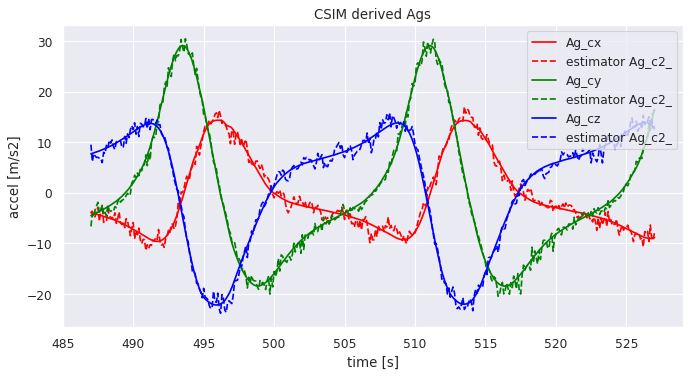

In [43]:
#Compare these 2 Ag_c's
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k');
ax = fig.add_subplot(111)

for ii in range(0,3):
    ax.plot(time_c,Ag_c[:,ii], label='Ag_c'+coords[ii],color=colors[ii])
    ax.plot(time_c[::5],Ag_c2[:,ii], label='estimator Ag_c2_',color=colors[ii],linestyle='--')
    
#ax.set_aspect('equal')
plt.xlabel('time [s]')
plt.ylabel('accel [m/s2]')
plt.title('CSIM derived Ags')
plt.legend(loc='best')
plt.show()

### From the above plot, we can conclude that Ag_c (manipulation of Ab) is fine, and the estimator has noise in it, which is more realistic.  In the next cell create Ag_c2k, i.e. Ag_c in KiteFAST reference frame

In [44]:
Ag_c2k=np.matmul(dcm_cg2fg, Ag_c.transpose()  ).transpose()
Ag_norm_c=np.linalg.norm(Ag_c2k,axis=1)
Ag_norm_c 

array([ 9.7625356 ,  9.7699048 ,  9.77751754, ..., 22.36925186,
       22.47907915, 22.58829744])

In [45]:
#Then create euler angles from the dcms based on kfast reference
r_k=myRotation.from_dcm(dcm_g2b_c2k.transpose([0,2,1]))
euler_c2k=r_k.as_euler('XYZ', degrees=False) 
#Also create rotvecs used by MBDYN in the file driver input file
rotvec_c2k=r_k.as_rotvec() 

In [46]:
# You may also use one of the two following commands to define mip_rf in KiteMain.set, as printed out below
print(('reference, global, euler, degrees, '+3*'{:.13f}, ').format(*np.rad2deg(euler_c2k[0,:])))
print(('reference, global, vector, '+3*'{:.13f}, ').format(*rotvec_c2k[0,:]))

reference, global, euler, degrees, -168.0748196337274, -42.3238076007010, 136.1663971520833, 
reference, global, vector, 1.0128879580870, -2.2504065747737, -0.5952228389383, 


In [47]:
# to compare to CSIM version of euler 
print(('CSIM-frame euler angles, degrees, '+3*'{:.13f}, ').format(*np.rad2deg(euler_c2k[0,:])))

CSIM-frame euler angles, degrees, -168.0748196337274, -42.3238076007010, 136.1663971520833, 


In [48]:
 # CSIM omega -  THESE ARE IN  BODY REFERENCE
omega_c=csim_dset['omega'][tel_idx0:]  #the 'd' gets the double stuff out as (n,3,3)
omega_c=np.array(omega_c.tolist(),dtype='float')

#For MBDYN initialization we need to transform them to global

init_omegag_k=np.matmul(dcm_g2b_c2k[0,:,:],omega_c[0,:])
print(('reference, global, ' + 3*'{:.10f}, ').format(*init_omegag_k))

reference, global, -0.0045340414, -0.1518348500, 0.1858510640, 


In [49]:
testrot=myRotation.from_euler('XYZ',euler_c2k[0,:])
testrot.as_dcm()

array([[-0.53333421, -0.51204989, -0.67331979],
       [-0.77798222,  0.60942873,  0.15277528],
       [ 0.33211185,  0.60531111, -0.7233949 ]])

In [50]:
theNotebook

'STIvsCSIM'

In [51]:
time_c.shape, dcm_g2b_c2k.shape

((2001,), (2001, 3, 3))

### Now Read In STI output, which is obtained runninig KFCdriver in standalone mode with KFCmode=1: 

## >>> ~/sandbox/build/modules/kitefast-controller/kitefastcontroller_driver     RRD_CTRLDRIVER_input.dat

In [52]:
#first set up labels and round up the CSIM outputs that will be checked against STI
nmotstr=np.linspace(1,nmotors,nmotors)
nmotstr=[str(int(i)) for i in nmotstr]
nflapstr=np.linspace(1,nflaps,nflaps)
nflapstr=[str(int(i)) for i in nflapstr]

Gentorquestr= np.core.defchararray.add(np.tile('GenTorq',nmotors),np.core.defchararray.add(nmotstr, ' [Nm]'))
RtrSpdstr= np.core.defchararray.add(np.tile('RtrSpd',nmotors),np.core.defchararray.add(nmotstr, ' [rad/s]'))
RtrAccstr= np.core.defchararray.add(np.tile('RtrAcc',nmotors),np.core.defchararray.add(nmotstr, ' [rad/s^2]'))
RtrPitchstr= np.core.defchararray.add(np.tile('BlPitch',nmotors),np.core.defchararray.add(nmotstr, ' [rad]'))
Flapstr= np.core.defchararray.add(np.tile('Flap',nflaps),np.core.defchararray.add(nflapstr, ' [rad]'))

nmotstr,Gentorquestr,Flapstr

(['1', '2', '3', '4', '5', '6', '7', '8'],
 array(['GenTorq1 [Nm]', 'GenTorq2 [Nm]', 'GenTorq3 [Nm]', 'GenTorq4 [Nm]',
        'GenTorq5 [Nm]', 'GenTorq6 [Nm]', 'GenTorq7 [Nm]', 'GenTorq8 [Nm]'],
       dtype='<U13'),
 array(['Flap1 [rad]', 'Flap2 [rad]', 'Flap3 [rad]', 'Flap4 [rad]',
        'Flap5 [rad]', 'Flap6 [rad]', 'Flap7 [rad]', 'Flap8 [rad]'],
       dtype='<U11'))

In [53]:
#blade pitch is 0 by default
blpitch_c=np.zeros_like(gen_torque_c)

csim_out_str=('#  {:>15s}'+(4*nmotors+nflaps)*'{:>18s}'+'\n').format(*np.hstack(['t[s]',Gentorquestr,RtrSpdstr,RtrAccstr,RtrPitchstr, Flapstr,'\n']).tolist())
csim_outs=np.hstack([time_c2k, gen_torque_c, rot_speed_c, rot_accel_c,blpitch_c,  flaps_c])


# Finally Load KFC and STI output (one would be enough, but we do a sanity check)

In [54]:
# Read KFC Output 
df_kfc=pd.read_csv(path2kfcfile,header=1,squeeze=True,delim_whitespace=True,low_memory=False); #nrows=10,b

#df_kfc=df_kfc.iloc[2:,:]
df_kfc.head(10)

Time     Rot1GTq     Rot2GTq     Rot3GTq     Rot4GTq     Rot5GTq  \
0       s        (Nm)        (Nm)        (Nm)        (Nm)        (Nm)   
1  0.0000  -3.017E+01   2.170E+01   1.264E+01  -3.371E+00   6.198E+01   
2  0.0000   7.230E+02  -7.279E+02  -7.327E+02   7.373E+02  -6.764E+02   
3  0.0200   3.497E+02  -3.370E+02  -3.243E+02   3.115E+02  -4.674E+02   
4  0.0400  -5.770E+02   5.759E+02   5.745E+02  -5.729E+02   5.716E+02   
5  0.0600  -7.061E+02   7.116E+02   7.170E+02  -7.223E+02   6.565E+02   
6  0.0800  -6.936E+02   6.990E+02   7.044E+02  -7.097E+02   6.452E+02   
7  0.1000  -6.810E+02   6.862E+02   6.915E+02  -6.968E+02   6.342E+02   
8  0.1200  -6.685E+02   6.735E+02   6.786E+02  -6.837E+02   6.235E+02   
9  0.1400  -6.562E+02   6.610E+02   6.658E+02  -6.707E+02   6.131E+02   

      Rot6GTq     Rot7GTq     Rot8GTq     Rot1Spd  ...   DCMG2Bc3    DCMG2Bc4  \
0        (Nm)        (Nm)        (Nm)     (Rad/s)  ...        (-)         (-)   
1  -6.899E+01  -7.614E+01   8.309E+01  -1.470E+02  ...  0.000E+00   0.000E+00   
2   6.712E+02   6.662E+02  -6.612E+02  -1.421E+02  ...  6.733E-01  -7.780E-01   
3   4.792E+02   4.907E+02  -5.020E+02  -1.396E+02  ...  6.731E-01  -7.806E-01   
4  -5.722E+02  -5.730E+02   5.737E+02  -1.431E+02  ...  6.730E-01  -7.831E-01   
5  -6.512E+02  -6.461E+02   6.411E+02  -1.474E+02  ...  6.728E-01  -7.857E-01   
6  -6.402E+02  -6.353E+02   6.306E+02  -1.516E+02  ...  6.726E-01  -7.882E-01   
7  -6.294E+02  -6.248E+02   6.204E+02  -1.557E+02  ...  6.725E-01  -7.907E-01   
8  -6.189E+02  -6.146E+02   6.104E+02  -1.597E+02  ...  6.724E-01  -7.932E-01   
9  -6.088E+02  -6.047E+02   6.007E+02  -1.637E+02  ...  6.722E-01  -7.957E-01   

    DCMG2Bc5   DCMG2Bc6    DCMG2Bc7    DCMG2Bc8   DCMG2Bc9     TethFxb  \
0        (-)        (-)         (-)         (-)        (-)         (N)   
1  0.000E+00  0.000E+00   0.000E+00   0.000E+00  0.000E+00   0.000E+00   
2  6.094E-01  1.528E-01  -3.321E-01  -6.053E-01  7.234E-01  -6.121E+03   
3  6.057E-01  1.543E-01  -3.285E-01  -6.075E-01  7.232E-01  -6.119E+03   
4  6.020E-01  1.558E-01  -3.248E-01  -6.096E-01  7.231E-01  -6.116E+03   
5  5.983E-01  1.573E-01  -3.212E-01  -6.118E-01  7.229E-01  -6.113E+03   
6  5.946E-01  1.588E-01  -3.175E-01  -6.139E-01  7.227E-01  -6.111E+03   
7  5.908E-01  1.603E-01  -3.138E-01  -6.160E-01  7.225E-01  -6.108E+03   
8  5.870E-01  1.618E-01  -3.101E-01  -6.181E-01  7.223E-01  -6.106E+03   
9  5.832E-01  1.633E-01  -3.064E-01  -6.202E-01  7.221E-01  -6.103E+03   

      TethFyb    TethFzb  
0         (N)        (N)  
1   0.000E+00  0.000E+00  
2  -6.010E+03  5.434E+04  
3  -5.995E+03  5.426E+04  
4  -5.981E+03  5.418E+04  
5  -5.967E+03  5.411E+04  
6  -5.953E+03  5.403E+04  
7  -5.939E+03  5.396E+04  
8  -5.926E+03  5.389E+04  
9  -5.912E+03  5.382E+04  

[10 rows x 37 columns]

In [55]:
# Read STI Output 
df_sti=pd.read_csv(path2STIOuts,header=3,index_col=False,skipinitialspace=True,low_memory=False); #nrows=10,b
df_sti.head(10)

time    dcm0_0    dcm0_1    dcm0_2    dcm1_0    dcm1_1    dcm1_2    dcm2_0  \
0  0.00  0.533334 -0.777982 -0.332112  0.512050  0.609429 -0.605311  0.673320   
1  0.02  0.531811 -0.780566 -0.328471  0.513868  0.605737 -0.607472  0.673139   
2  0.04  0.530277 -0.783134 -0.324818  0.515675  0.602027 -0.609625  0.672968   
3  0.06  0.528731 -0.785686 -0.321154  0.517472  0.598299 -0.611769  0.672805   
4  0.08  0.527175 -0.788222 -0.317478  0.519258  0.594554 -0.613902  0.672650   
5  0.10  0.525607 -0.790742 -0.313791  0.521036  0.590791 -0.616025  0.672502   
6  0.12  0.524027 -0.793246 -0.310092  0.522805  0.587010 -0.618137  0.672362   
7  0.14  0.522435 -0.795734 -0.306381  0.524565  0.583211 -0.620239  0.672230   
8  0.16  0.520832 -0.798205 -0.302659  0.526315  0.579394 -0.622330  0.672106   
9  0.18  0.519217 -0.800660 -0.298926  0.528055  0.575560 -0.624410  0.671990   

     dcm2_1    dcm2_2  ...   aileron  inboard_flap  midboard_flap  \
0  0.152775  0.723395  ... -0.069643           0.0            0.0   
1  0.154270  0.723246  ... -0.050167           0.0            0.0   
2  0.155769  0.723084  ... -0.021997           0.0            0.0   
3  0.157273  0.722910  ... -0.001544           0.0            0.0   
4  0.158781  0.722725  ...  0.002402           0.0            0.0   
5  0.160290  0.722529  ...  0.005120           0.0            0.0   
6  0.161803  0.722322  ...  0.006200           0.0            0.0   
7  0.163318  0.722104  ...  0.005574           0.0            0.0   
8  0.164836  0.721874  ...  0.005258           0.0            0.0   
9  0.166355  0.721634  ...  0.005255           0.0            0.0   

   outboard_flap  elevator    rudder   thrust  moment_x   moment_y  \
0            0.0 -0.033477  0.014619  27850.0       0.0 -10.785942   
1            0.0 -0.034588  0.002918  27700.0       0.0  -8.900076   
2            0.0 -0.034645 -0.010010  27550.0       0.0  -8.619117   
3            0.0 -0.037897 -0.030751  27400.0       0.0  -3.251717   
4            0.0 -0.049351 -0.027723  27250.0       0.0  15.100318   
5            0.0 -0.059550 -0.025436  27100.0       0.0  31.522676   
6            0.0 -0.062954 -0.021099  26950.0       0.0  37.259850   
7            0.0 -0.058015 -0.013846  26800.0       0.0  29.858238   
8            0.0 -0.053413 -0.007343  26650.0       0.0  23.007546   
9            0.0 -0.049123 -0.001496  26500.0       0.0  16.667918   

      moment_z  
0   635.705374  
1  1078.135213  
2  1559.108769  
3  2374.937124  
4  2239.789058  
5  2137.658548  
6  1954.187100  
7  1653.636470  
8  1383.781474  
9  1140.716803  

[10 rows x 111 columns]

# Extract time into 1 var

In [56]:
time_kfc=df_kfc.loc[1:,'Time'].values.astype('float')[1:] #this one had an extra line with 0s
time_sti=df_sti.loc[0:,'time'].values.astype('float')

dt_kfc=time_kfc[1]-time_kfc[0]
dt_sti=time_sti[1]-time_sti[0]

time_kfc[0:3],time_sti[0:3]
dt_kfc, dt_c, dt_sti, time_kfc.shape, time_sti.shape, time_c2k.shape


(0.02, 0.01999999999998181, 0.02, (2001,), (2001,), (2001, 1))

# Rotor Speeds, accels, & Generator Torques

In [57]:
# KFC GenTorques: They need to come from KFCdriver_test.KFC.out
#Note in KiteFAST.KFC.out the generator torques are ordered 1--8 following CSIM already 
ctr1=np.linspace(1,nmotors,nmotors,dtype=int).astype('str')
gTq_kfc_str=np.core.defchararray.add(np.tile('Rot',nmotors),ctr1)
gTq_kfc_str=np.core.defchararray.add(gTq_kfc_str,np.tile('GTq',nmotors))
#Then the STI ones
ctr2=np.linspace(0,nmotors-1,nmotors,dtype=int).astype('str')
gTq_sti_str=np.core.defchararray.add(np.tile('r_torque[',nmotors),ctr2)
gTq_sti_str=np.core.defchararray.add(gTq_sti_str,np.tile(']',nmotors))

gTq_kfc_str,gTq_sti_str

(array(['Rot1GTq', 'Rot2GTq', 'Rot3GTq', 'Rot4GTq', 'Rot5GTq', 'Rot6GTq',
        'Rot7GTq', 'Rot8GTq'], dtype='<U27'),
 array(['r_torque[0]', 'r_torque[1]', 'r_torque[2]', 'r_torque[3]',
        'r_torque[4]', 'r_torque[5]', 'r_torque[6]', 'r_torque[7]'],
       dtype='<U31'))

In [58]:
# KFC rotspeeds: They need to come from KFCdriver_test.KFC.out

gSpd_kfc_str=np.core.defchararray.add(np.tile('Rot',nmotors),ctr1)
gSpd_kfc_str=np.core.defchararray.add(gSpd_kfc_str,np.tile('Spd',nmotors))
#Then the STI ones
ctr=np.linspace(0,nmotors-1,nmotors,dtype=int).astype('str')
gSpd_sti_str=np.core.defchararray.add(np.tile('rotors[',nmotors),ctr2)
gSpd_sti_str=np.core.defchararray.add(gSpd_sti_str,np.tile(']',nmotors))

gSpd_kfc_str,gSpd_sti_str

(array(['Rot1Spd', 'Rot2Spd', 'Rot3Spd', 'Rot4Spd', 'Rot5Spd', 'Rot6Spd',
        'Rot7Spd', 'Rot8Spd'], dtype='<U27'),
 array(['rotors[0]', 'rotors[1]', 'rotors[2]', 'rotors[3]', 'rotors[4]',
        'rotors[5]', 'rotors[6]', 'rotors[7]'], dtype='<U29'))

In [59]:
#
gTq_kfc=df_kfc.loc[2:,gTq_kfc_str].astype('float').to_numpy()
#gTq_kfc.describe()

gTq_sti=df_sti.loc[:,gTq_sti_str].astype('float').to_numpy()
#gTq_sti.describe()

gSpd_kfc=df_kfc.loc[2:,gSpd_kfc_str].astype('float').to_numpy()
#gSpd_kfc.describe()

gSpd_sti=df_sti.loc[:,gSpd_sti_str].astype('float').to_numpy()
#gSpd_sti.describe()
gTq_kfc.shape,gTq_sti.shape,gSpd_kfc.shape,gSpd_sti.shape,time_kfc.shape,aero_torque_c[300,0]

((2001, 8), (2001, 8), (2001, 8), (2001, 8), (2001,), -514.9437581645947)

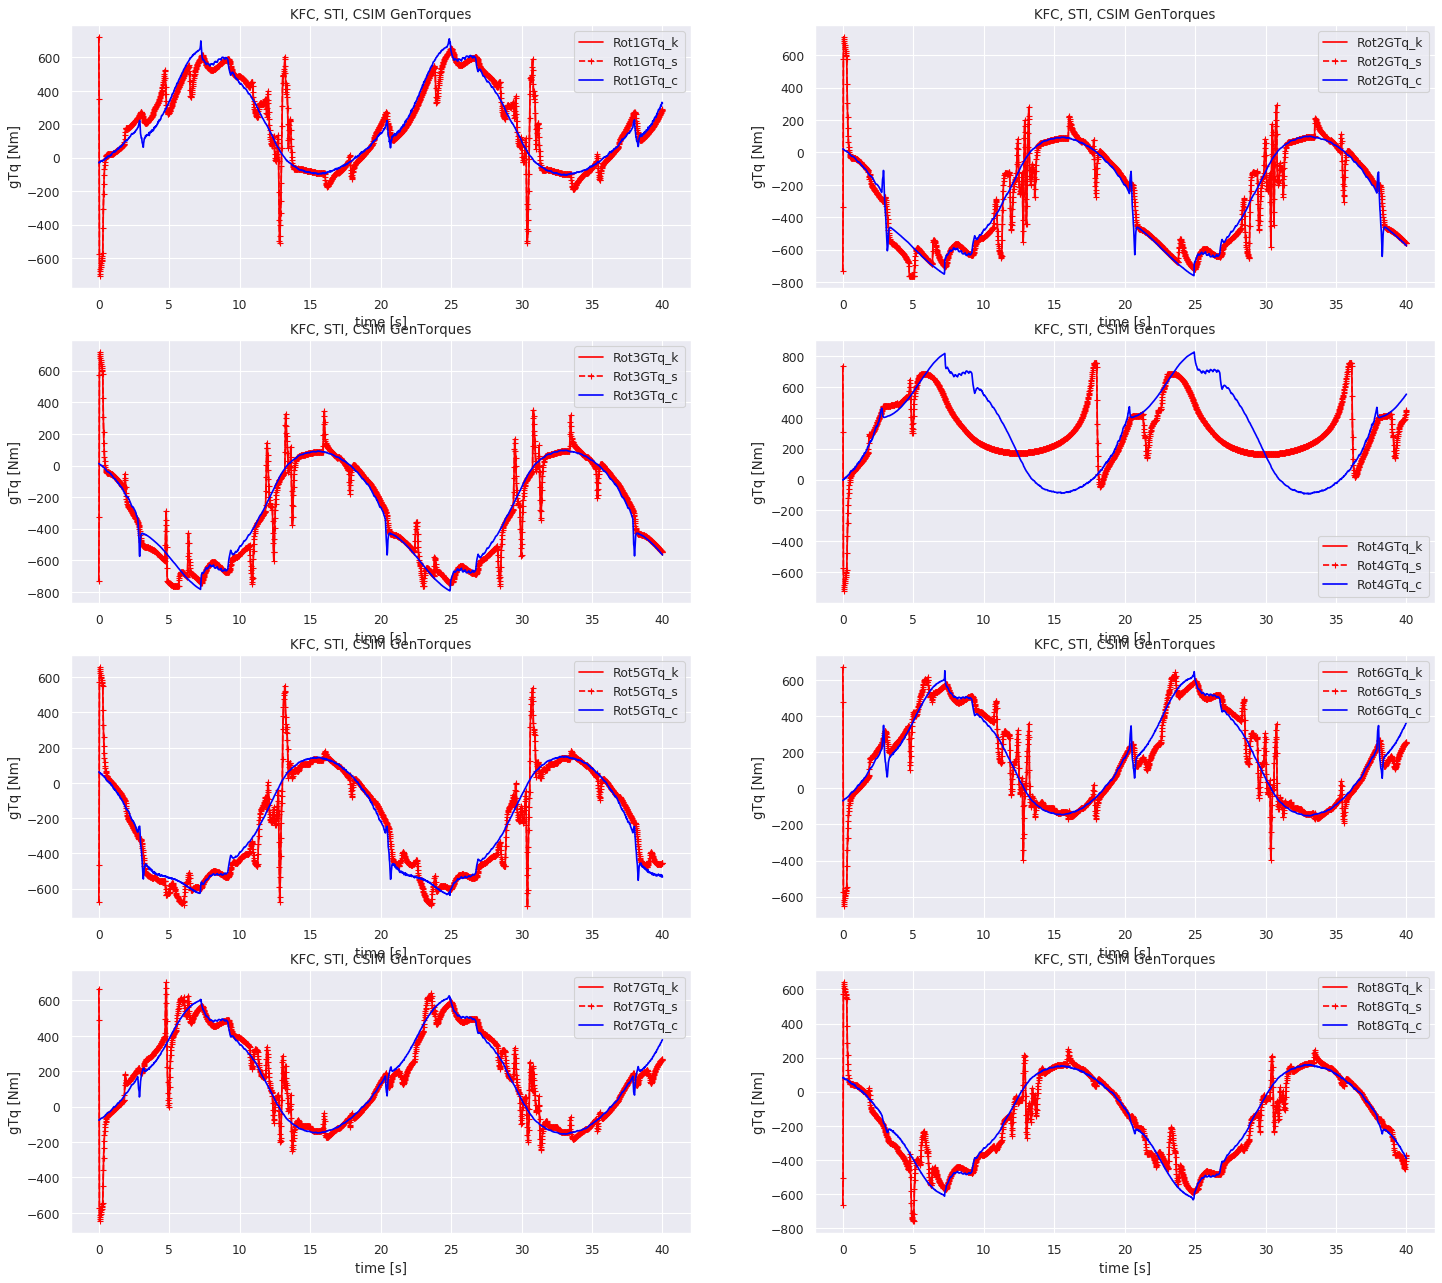

In [60]:
#Plot Gtorques and Gspeeds: KFC, STI, CSIM
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(22, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_kfc,gTq_kfc[:,irot],label=gTq_kfc_str[irot]+'_k',color='red')
    ax[irot].plot(time_sti,gTq_sti[:,irot],label=gTq_kfc_str[irot]+'_s',color='red',linestyle='--',marker='+')
    ax[irot].plot(time_c2k,gen_torque_c[:,irot],label=gTq_kfc_str[irot]+'_c',color='blue')
    #ax[irot].plot(time_c2k,aero_torque_c[:,irot],label='aeroTq'+ str(irot) +'_c',color='cyan')
    
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('gTq [Nm]')
    ax[irot].set_title('KFC, STI, CSIM GenTorques')
    plt.legend(loc='best')

plt.show()

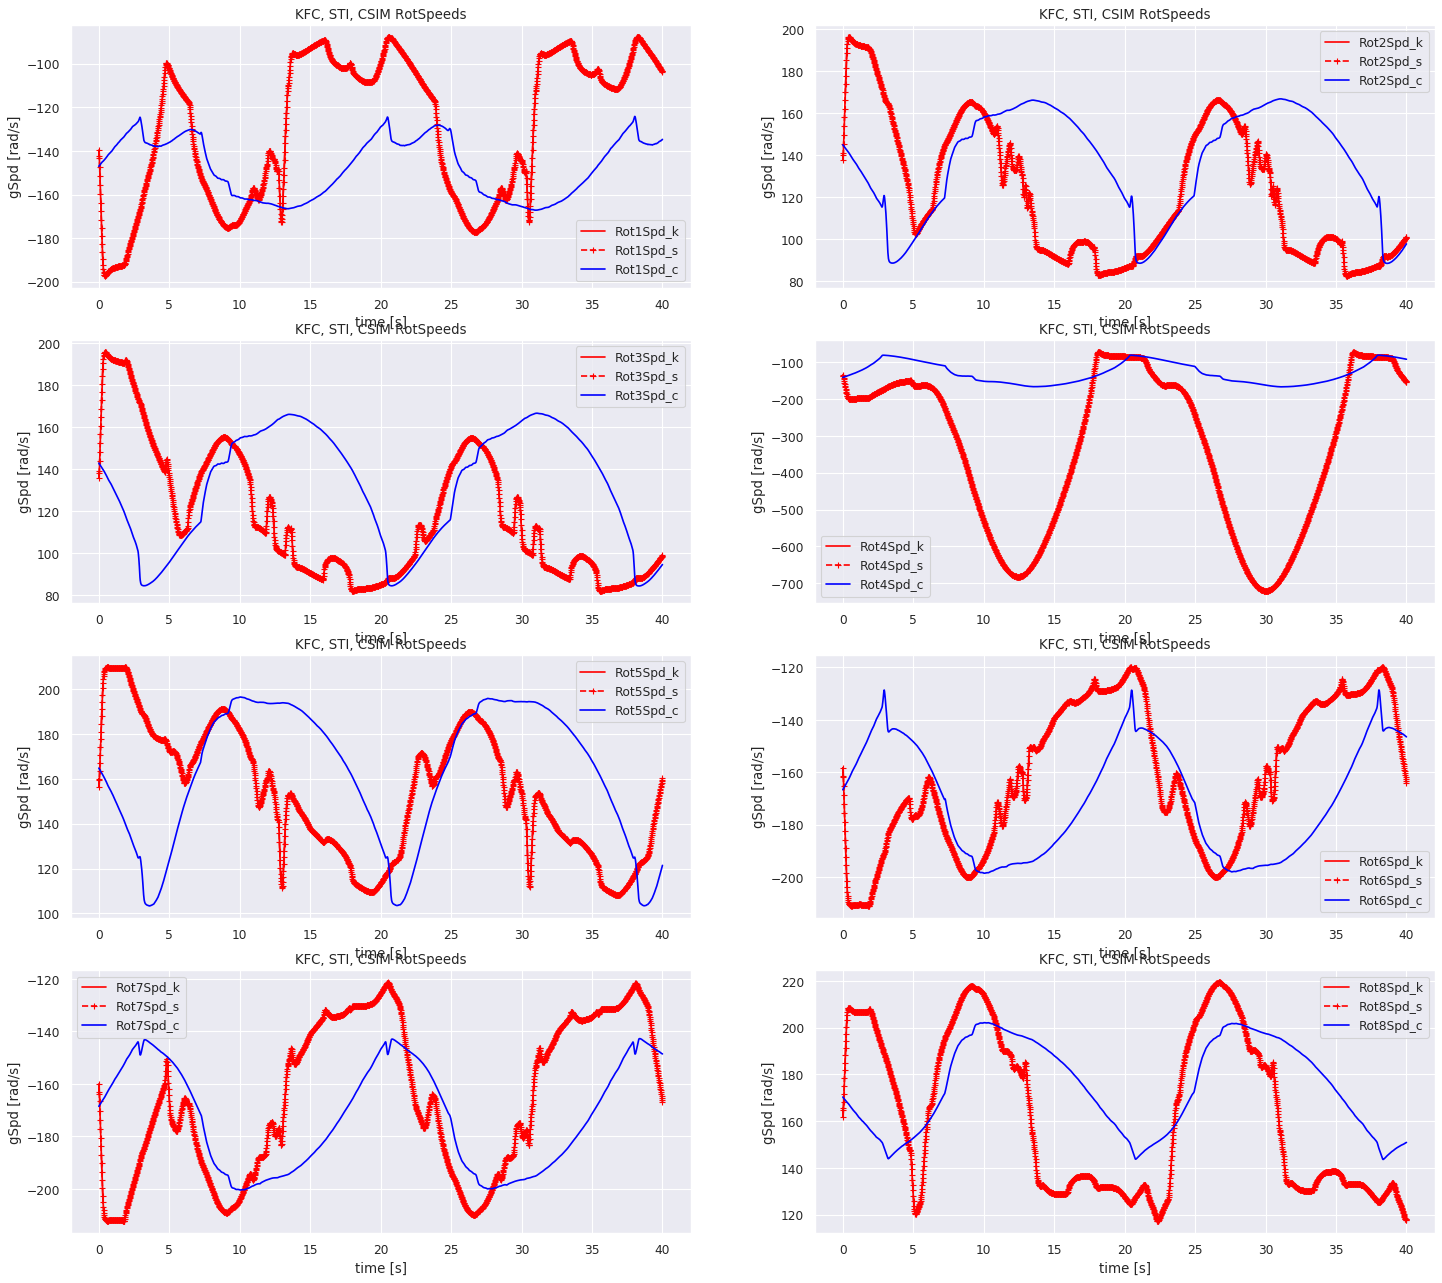

In [61]:
#Plot Gspeeds: KFC, STI, CSIM
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(22, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_kfc,gSpd_kfc[:,irot],label=gSpd_kfc_str[irot]+'_k',color='red')
    ax[irot].plot(time_sti,gSpd_sti[:,irot],label=gSpd_kfc_str[irot]+'_s',color='red',linestyle='--',marker='+')
    ax[irot].plot(time_c2k,rot_speed_c[:,irot],label=gSpd_kfc_str[irot]+'_c',color='blue')
    
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('gSpd [rad/s]')
    ax[irot].set_title('KFC, STI, CSIM RotSpeeds')
    plt.legend(loc='best')

plt.show()

# READ Control Surfaces Now

In [62]:
# KFC Flapse: They need to come from KFCdriver_test.KFC.out
flaps_kfc_str=np.core.defchararray.add(np.tile('Flp',nmotors),ctr1)
flaps_kfc_str=np.core.defchararray.add(flaps_kfc_str,np.tile('Def',nmotors))
#Then the STI ones
flaps_sti_str=np.core.defchararray.add(np.tile('flaps[',nmotors),ctr2)
flaps_sti_str=np.core.defchararray.add(flaps_sti_str,np.tile(']',nmotors))

#arrays:
flaps_kfc=df_kfc.loc[2:,flaps_kfc_str].astype('float').to_numpy()
flaps_sti=df_sti.loc[:,flaps_sti_str].astype('float').to_numpy()

time_kfc.shape,flaps_kfc.shape

((2001,), (2001, 8))

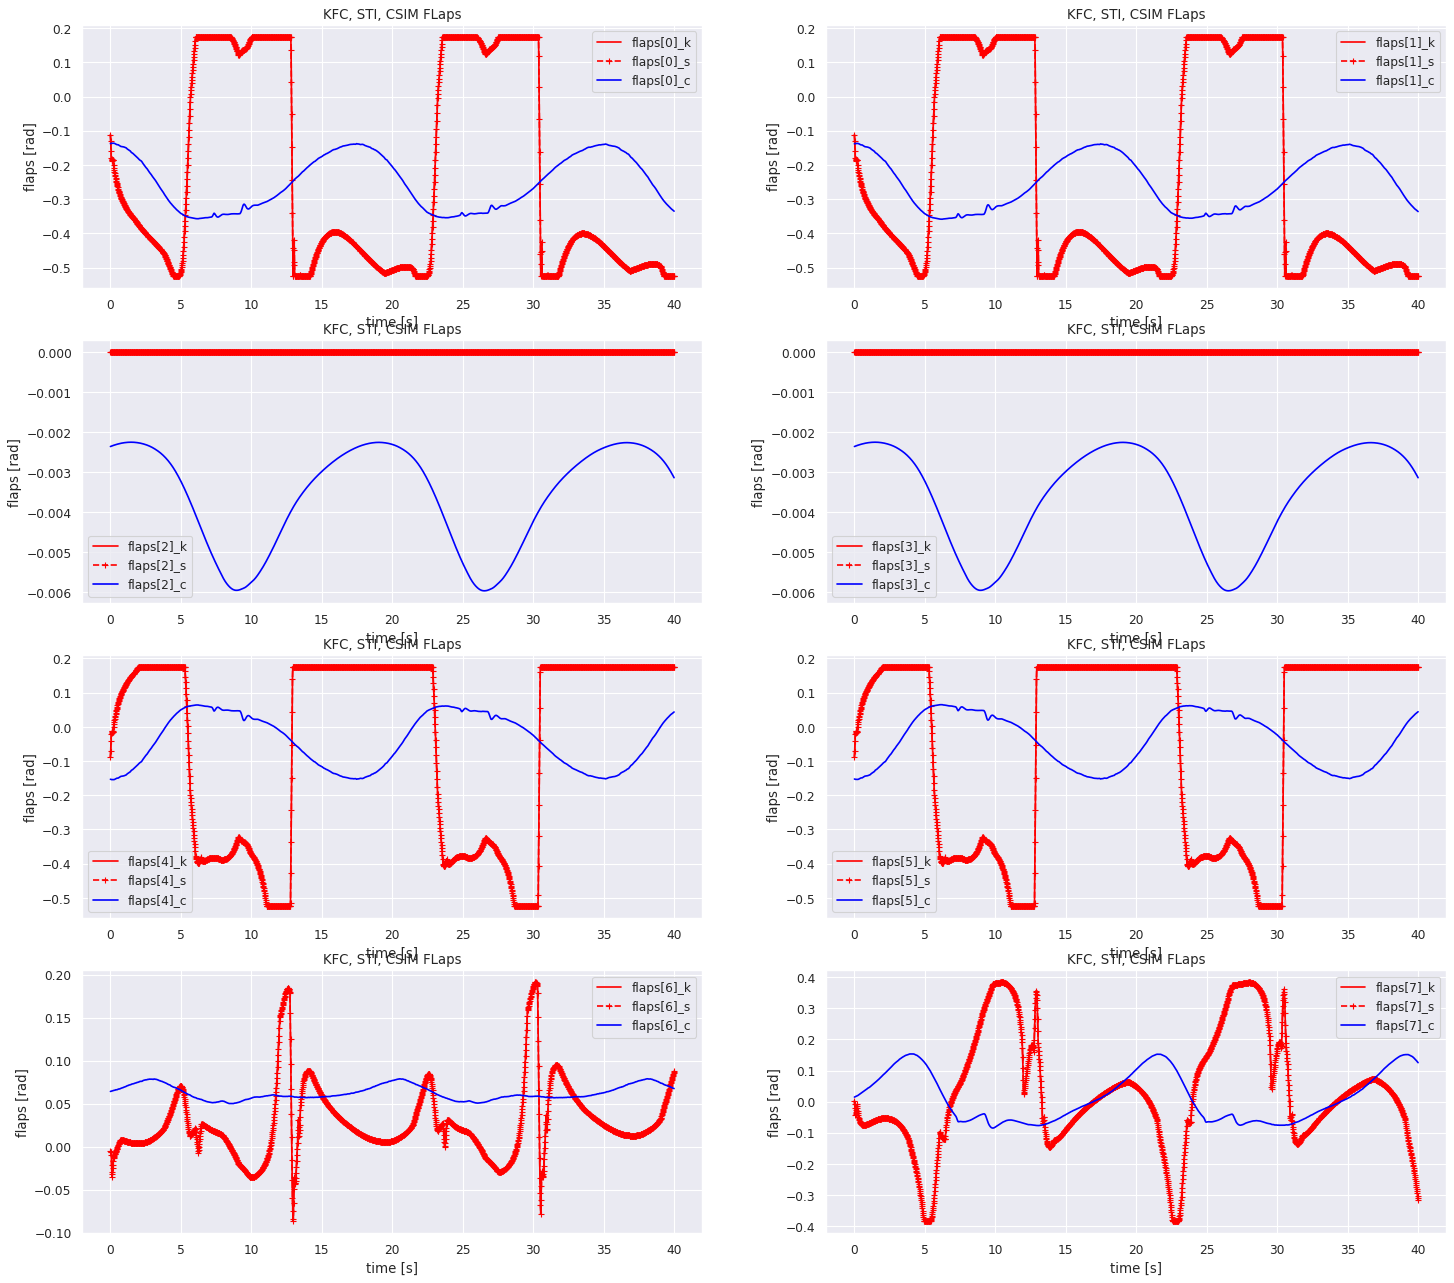

In [63]:
#Plot flaps: KFC, STI, CSIM
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(22, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_kfc,flaps_kfc[:,irot],label=flaps_sti_str[irot]+'_k',color='red')
    ax[irot].plot(time_sti,flaps_sti[:,irot],label=flaps_sti_str[irot]+'_s',color='red',linestyle='--',marker='+')
    ax[irot].plot(time_c2k,flaps_c[:,irot],label=flaps_sti_str[irot]+'_c',color='blue')
    
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('flaps [rad]')
    ax[irot].set_title('KFC, STI, CSIM FLaps')
    plt.legend(loc='best')

plt.show()

### Now read in the cmds from the STI controller

(2001, 1) (2001,)


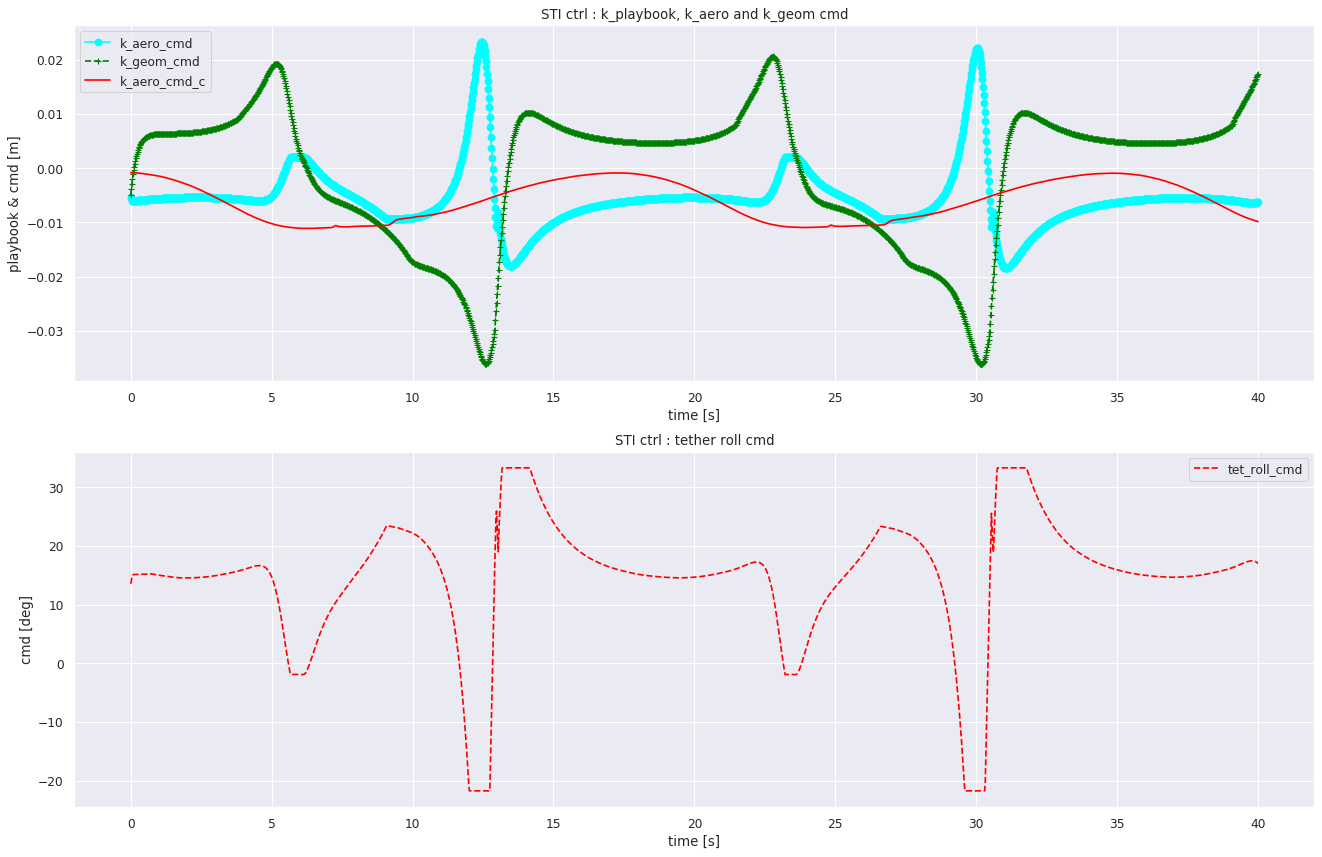

In [64]:
r_playbook=df_sti['path_rad_play_out'].to_numpy()
k_aero_cmd=df_sti['k_aero_cmd_pth_out'].to_numpy()
k_geom_cmd=df_sti['k_geom_cmd_pth_out'].to_numpy()
tet_roll_cmd=df_sti['tet_roll_cmd_crv_out'].to_numpy()

#add CSIM version
#tel2.dtype
#tel2['crosswind']['k_aero_cmd'].dtype
k_aero_cmd_c=tel3['crosswind']['k_aero_cmd'][tel3_idx0:]
k_geom_cmd_c=tel3['crosswind']['k_geom_cmd'][tel3_idx0:]
print(time_c2k.shape,k_aero_cmd_c[::2].shape)

ax=[None]*2

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,2):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    if ii<1:
       # ax[ii].plot(time_sti,r_playbook,label='k_playbook',color='blue')
        ax[ii].plot(time_sti,k_aero_cmd,label='k_aero_cmd',color='cyan',marker='o')
        ax[ii].plot(time_sti,k_geom_cmd,label='k_geom_cmd',color='green',linestyle='--',marker='+')
        ax[ii].plot(time_c2k,k_aero_cmd_c[::2],label='k_aero_cmd_c',color='red')
        ax[ii].set_title('STI ctrl : k_playbook, k_aero and k_geom cmd')
        ax[ii].set_ylabel('playbook & cmd [m]')
        #ax[ii].set_ylim(-18,180)
    else:
        ax[ii].plot(time_sti,np.rad2deg(tet_roll_cmd),label='tet_roll_cmd',color='red',linestyle='--')
        ax[ii].set_title('STI ctrl : tether roll cmd')
        ax[ii].set_ylabel('cmd [deg]')
    ax[ii].set_xlabel('time [s]')
    
    plt.legend(loc='best')
    
plt.show()


## Now Let us plot all the states to confirm STI and CSIM states match

### Tether forces

In [65]:
# KFC Flapse: They need to come from KFCdriver_test.KFC.out
teth_kfc_str=np.core.defchararray.add(np.tile('TethF',3),coords)
teth_kfc_str=np.core.defchararray.add(teth_kfc_str,np.tile('b',3))

#arrays:
teth_kfc=df_kfc.loc[2:,teth_kfc_str].astype('float').to_numpy()


time_kfc.shape,teth_kfc.shape

((2001,), (2001, 3))

In [87]:
#Tether force vector  by STI controller:
teth_sti_str=np.core.defchararray.add(np.tile('teth_vec_b.',ncoords),coords)
teth_sti_f=df_sti.loc[:,teth_sti_str].to_numpy()
teth_sti_f.shape


(2001, 3)

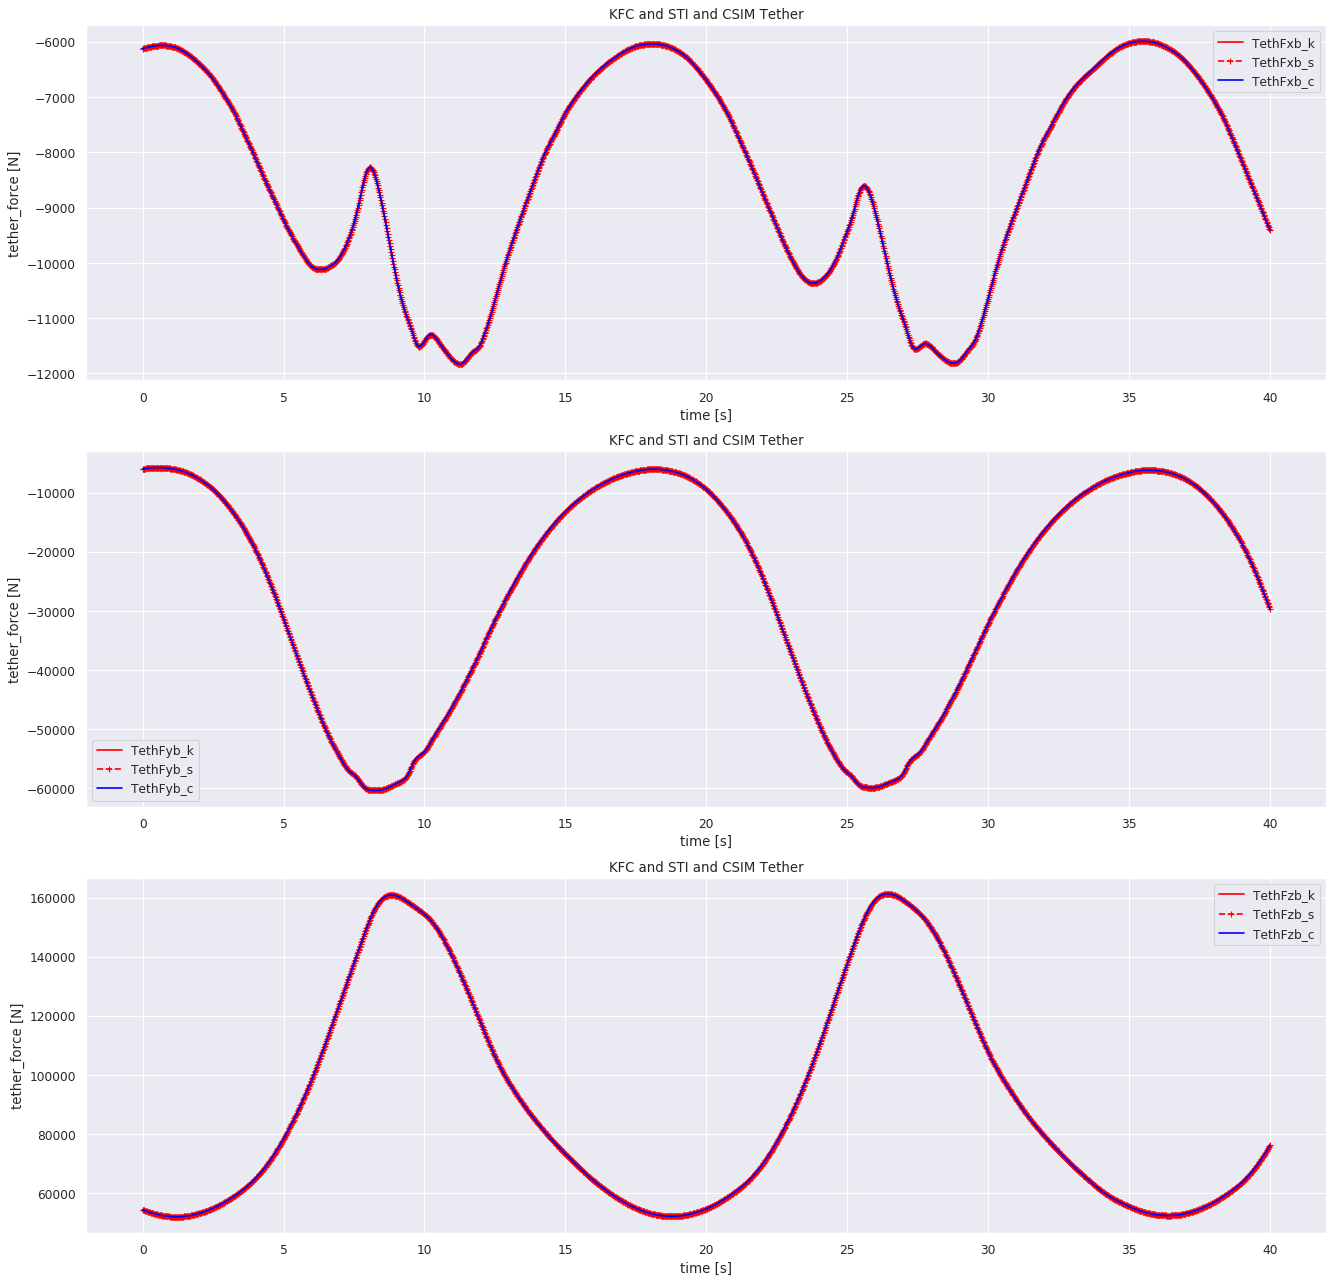

In [67]:
#Plot  filtered  tether forces
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)

    ax[ii].plot(time_kfc,teth_kfc[:,ii],label=teth_kfc_str[ii]+'_k',color='red')
    ax[ii].plot(time_sti,teth_sti_f[:,ii],label=teth_kfc_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_sti,tether_vec_c[:,ii],label=teth_kfc_str[ii]+'_c',color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_ylabel('tether_force [N]')
    ax[ii].set_title('KFC and STI and CSIM Tether')

    plt.legend(loc='best')
plt.show()

### DCMs: showing KFC output being transposed because it is showing the KFAST output. THis is correct. 
### Controller_conversion.c takes care of fixing things


In [68]:
ctr3=np.linspace(1,9,9,dtype=int).astype('str')
dcmg2b_kfc_str=np.core.defchararray.add(np.tile('DCMG2Bc',9),ctr3)

#Then the STI ones
dcmg2b_sti_str=['dcm0_0','dcm0_1','dcm0_2','dcm1_0','dcm1_1','dcm1_2','dcm2_0','dcm2_1','dcm2_2']

#arrays:
dcmg2b_kfc=df_kfc.loc[2:,dcmg2b_kfc_str].astype('float').to_numpy()
dcmg2b_sti=df_sti.loc[:,dcmg2b_sti_str].astype('float').to_numpy()

dcm_g2b_cplt=dcm_g2b_c.reshape([-1,9],order='C') #this is put into C, as this is the correct 3x3

time_kfc.shape,dcmg2b_kfc.shape,dcm_g2b_c.shape,dcm_g2b_cplt.shape


((2001,), (2001, 9), (2001, 3, 3), (2001, 9))

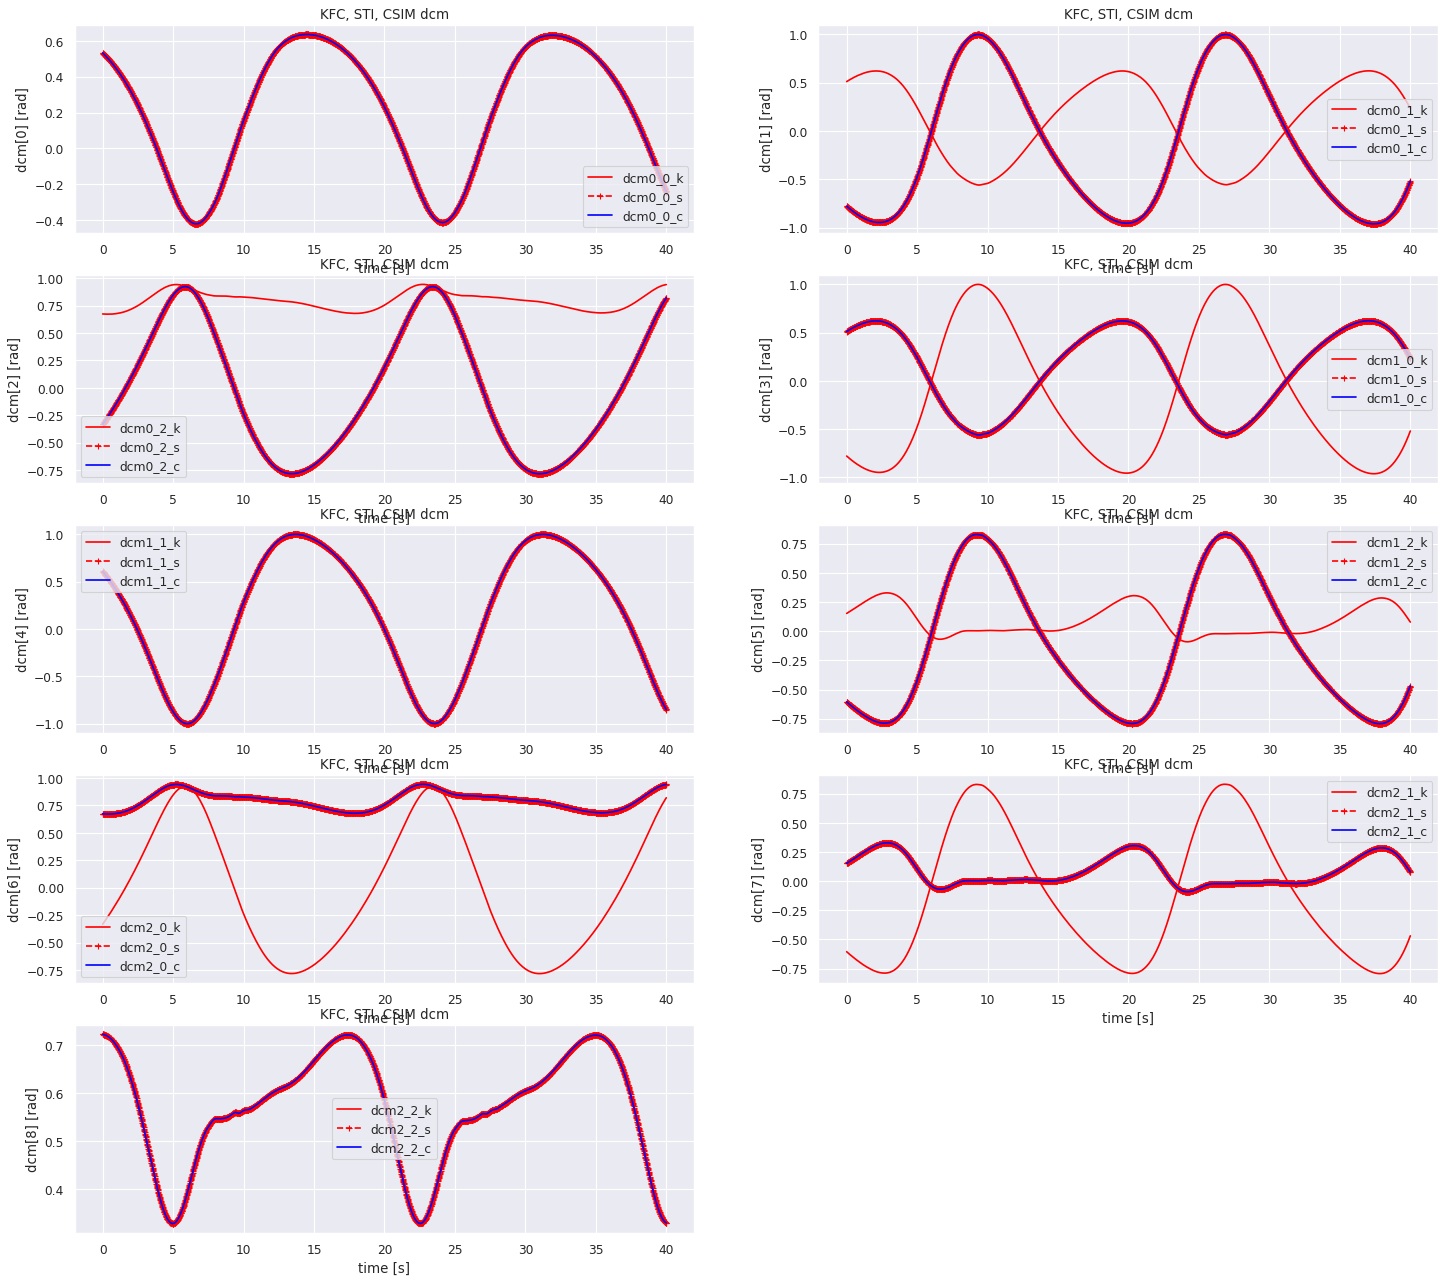

In [69]:
#Plot flaps: KFC, STI, CSIM: Note STI shows the correct 3x3, KFC has teh FORTRAN (KFAST style) DCM instead, so they should be transposed
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*9


fig= plt.figure(figsize=(22, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,9):
    ax[irot] = fig.add_subplot(5, 2, irot+1)
       
    ax[irot].plot(time_kfc,dcmg2b_kfc[:,irot],label=dcmg2b_sti_str[irot]+'_k',color='red')
    ax[irot].plot(time_sti,dcmg2b_sti[:,irot],label=dcmg2b_sti_str[irot]+'_s',color='red',linestyle='--',marker='+')
    ax[irot].plot(time_c2k,dcm_g2b_cplt[:,irot],label=dcmg2b_sti_str[irot]+'_c',color='blue')
    
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('dcm['+str(irot) + '] [rad]')
    ax[irot].set_title('KFC, STI, CSIM dcm')
    plt.legend(loc='best')

plt.show()

## Apparent Wind

In [70]:
#Do not have an apparent wind output from KFAST, I need to make sure STI and CSIM apparent winds match, that confirms states from KFAST were interpreted correctly
appw_sti_str=["app_wnd_f.v", "app_wnd_f.alpha", "app_wnd_f.beta"]

appw_sti=df_sti.loc[:,appw_sti_str].astype('float').to_numpy()

appw_sti.shape, apparent_wind_b_c.shape

((2001, 3), (2001, 3))

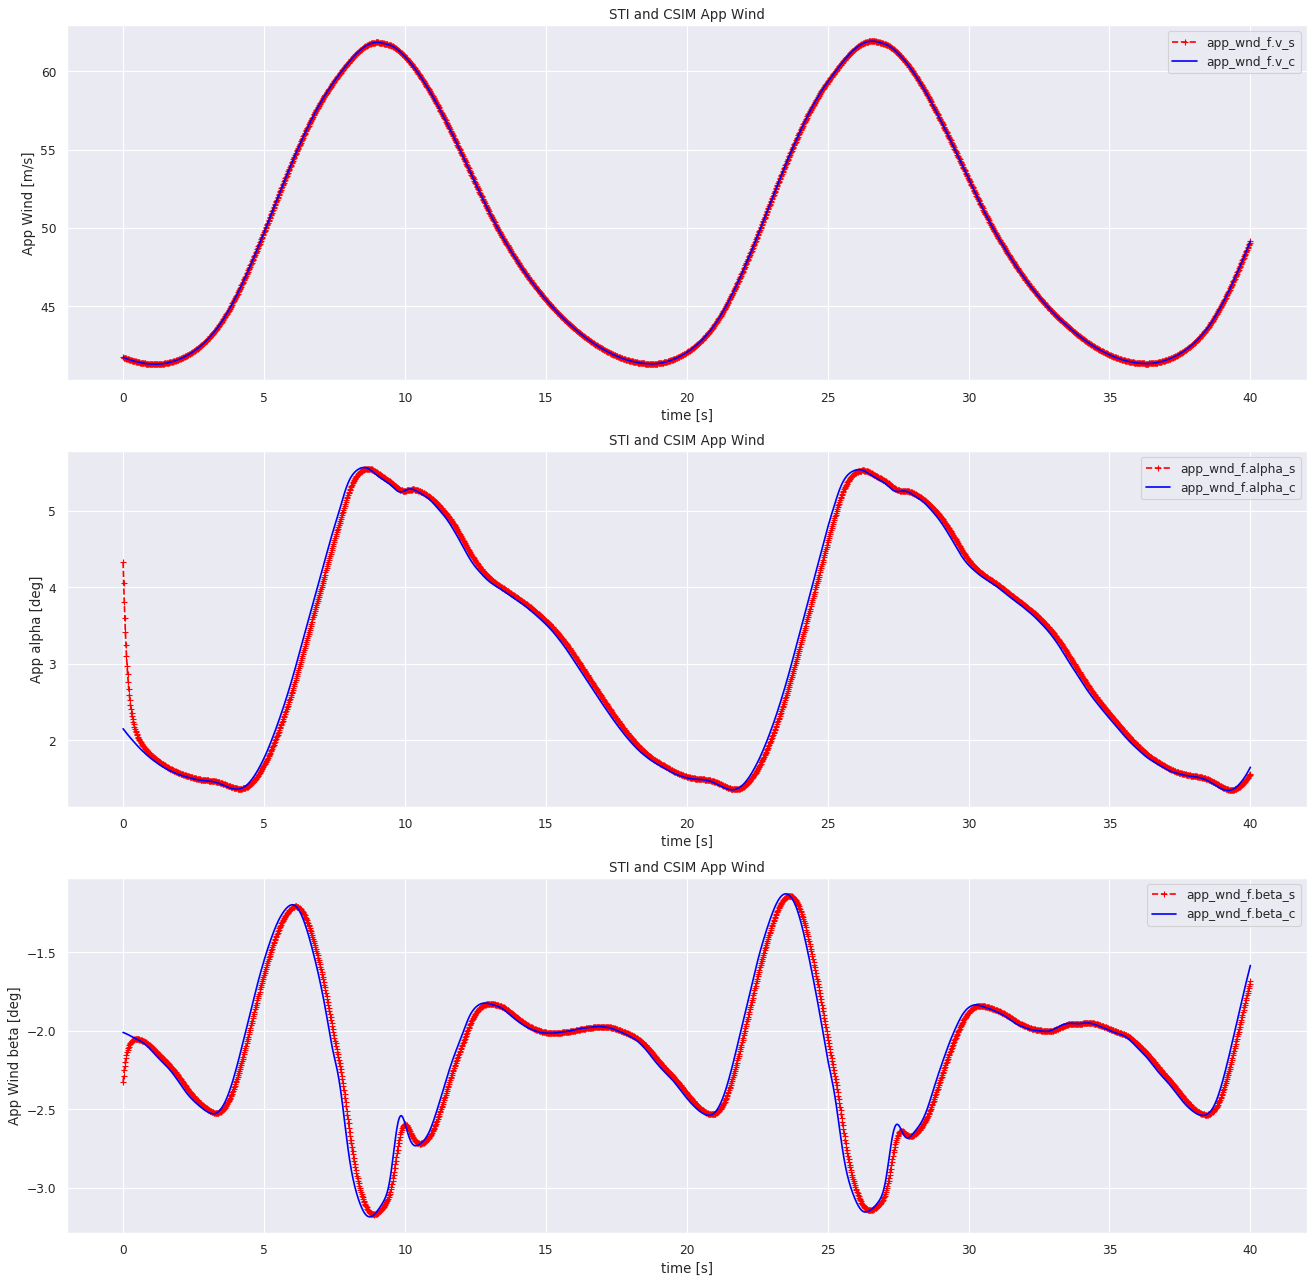

In [71]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
       
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM App Wind')
    
    if ii ==0:
        ax[ii].plot(time_sti,appw_sti[:,ii],label=appw_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
        ax[ii].plot(time_c2k,apparent_wind_b_c[:,ii],label=appw_sti_str[ii]+'_c',color='blue')
        ax[ii].set_ylabel('App Wind [m/s]')        
    else:
        ax[ii].plot(time_c2k,np.rad2deg(appw_sti[:,ii]),label=appw_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
        ax[ii].plot(time_c2k,np.rad2deg(apparent_wind_b_c[:,ii]),label=appw_sti_str[ii]+'_c',color='blue')
        if ii ==1:
            ax[ii].set_ylabel('App alpha [deg]')
        else:
            ax[ii].set_ylabel('App Wind beta [deg]')
        
    plt.legend(loc='best')
plt.show()

##  PQR.  STI will show the filtered version of it, and the ICs may be due to the control_glob structure by Justin

In [72]:
STI_pqrf_str=np.core.defchararray.add(np.tile('pqr_f.',ncoords),coords)
pqr_sti=df_sti.loc[:,STI_pqrf_str].to_numpy()
pqr_sti.shape

(2001, 3)

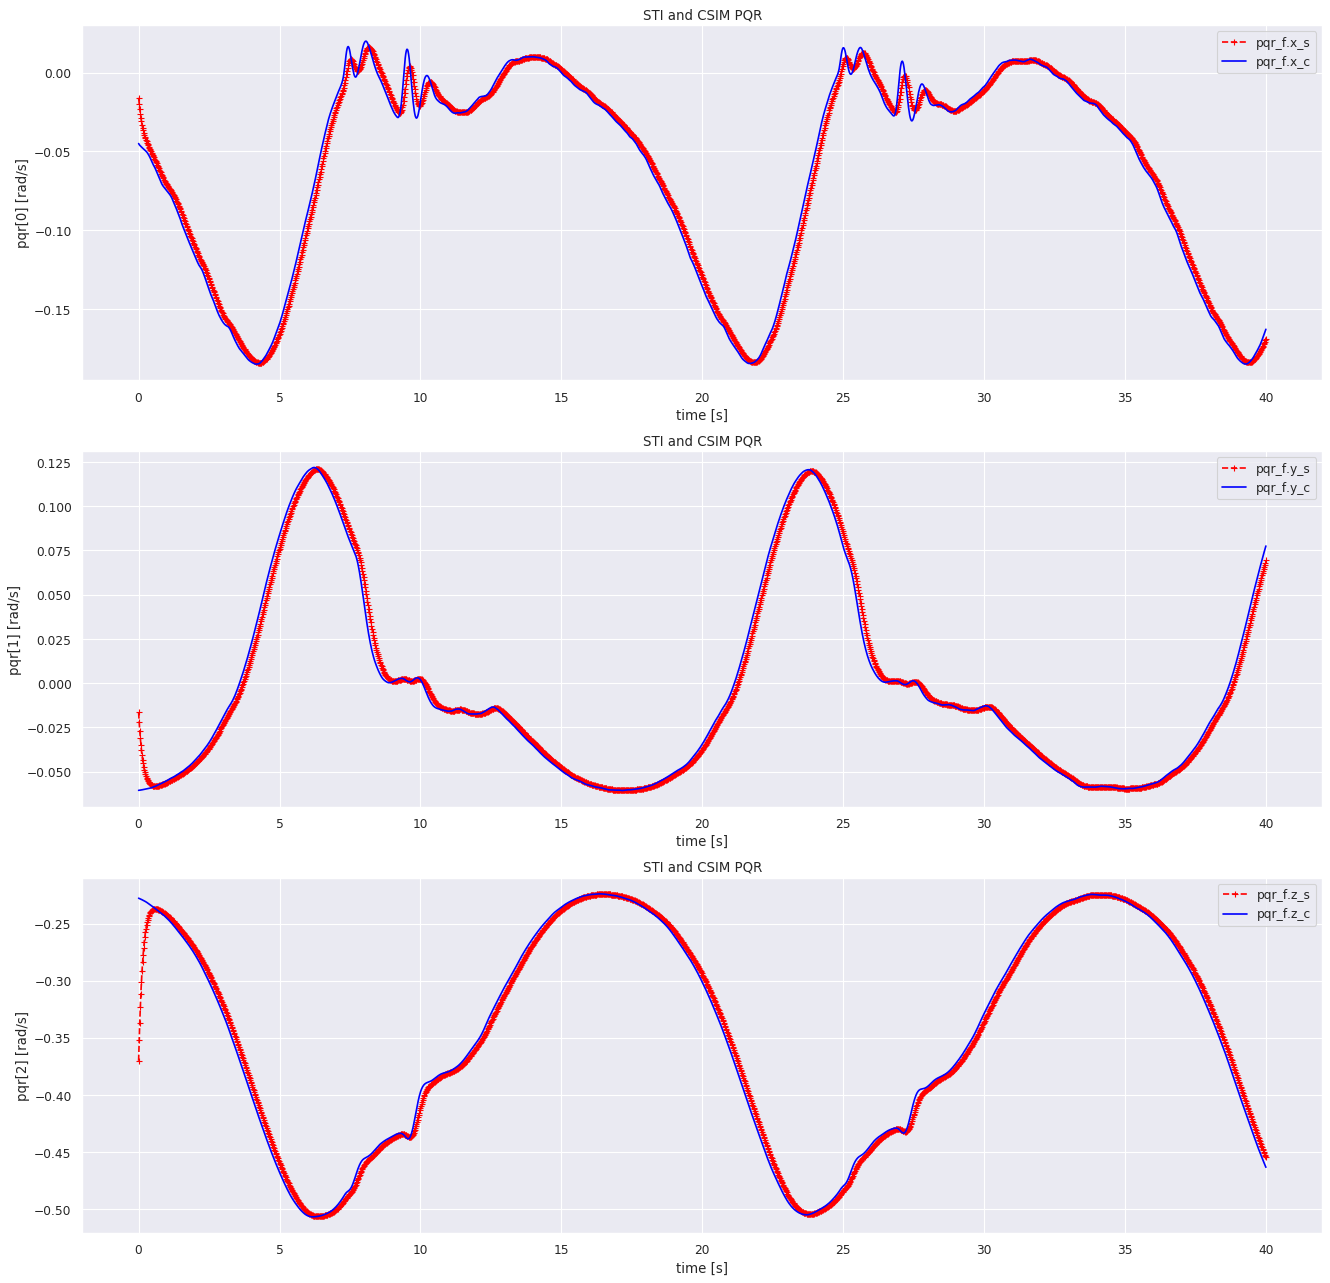

In [73]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
    ax[ii].plot(time_sti,pqr_sti[:,ii],label=STI_pqrf_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_c2k,omega_c[:,ii],label=STI_pqrf_str[ii]+'_c',color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM PQR')
    
    ax[ii].set_ylabel('pqr['+str(ii)+'] [rad/s]')        
        
    plt.legend(loc='best')
plt.show()

## Ab: the STI should show filtered versions

In [74]:
#Do not have an apparent wind output from KFAST, I need to make sure STI and CSIM apparent winds match, that confirms states from KFAST were interpreted correctly
Ab_sti_str=np.core.defchararray.add(np.tile('Ab_f.',3),coords)

Ab_sti=df_sti.loc[:,Ab_sti_str].astype('float').to_numpy()

Ab_sti.shape, Ab_c2k.shape, Ab_c2k[0:3,:]

((2001, 3), (2001, 3), array([[-1.15392349, -9.43911201,  2.20878391],
        [-1.14063751, -9.44789414,  2.21071983],
        [-1.12777359, -9.45701028,  2.21199741]]))

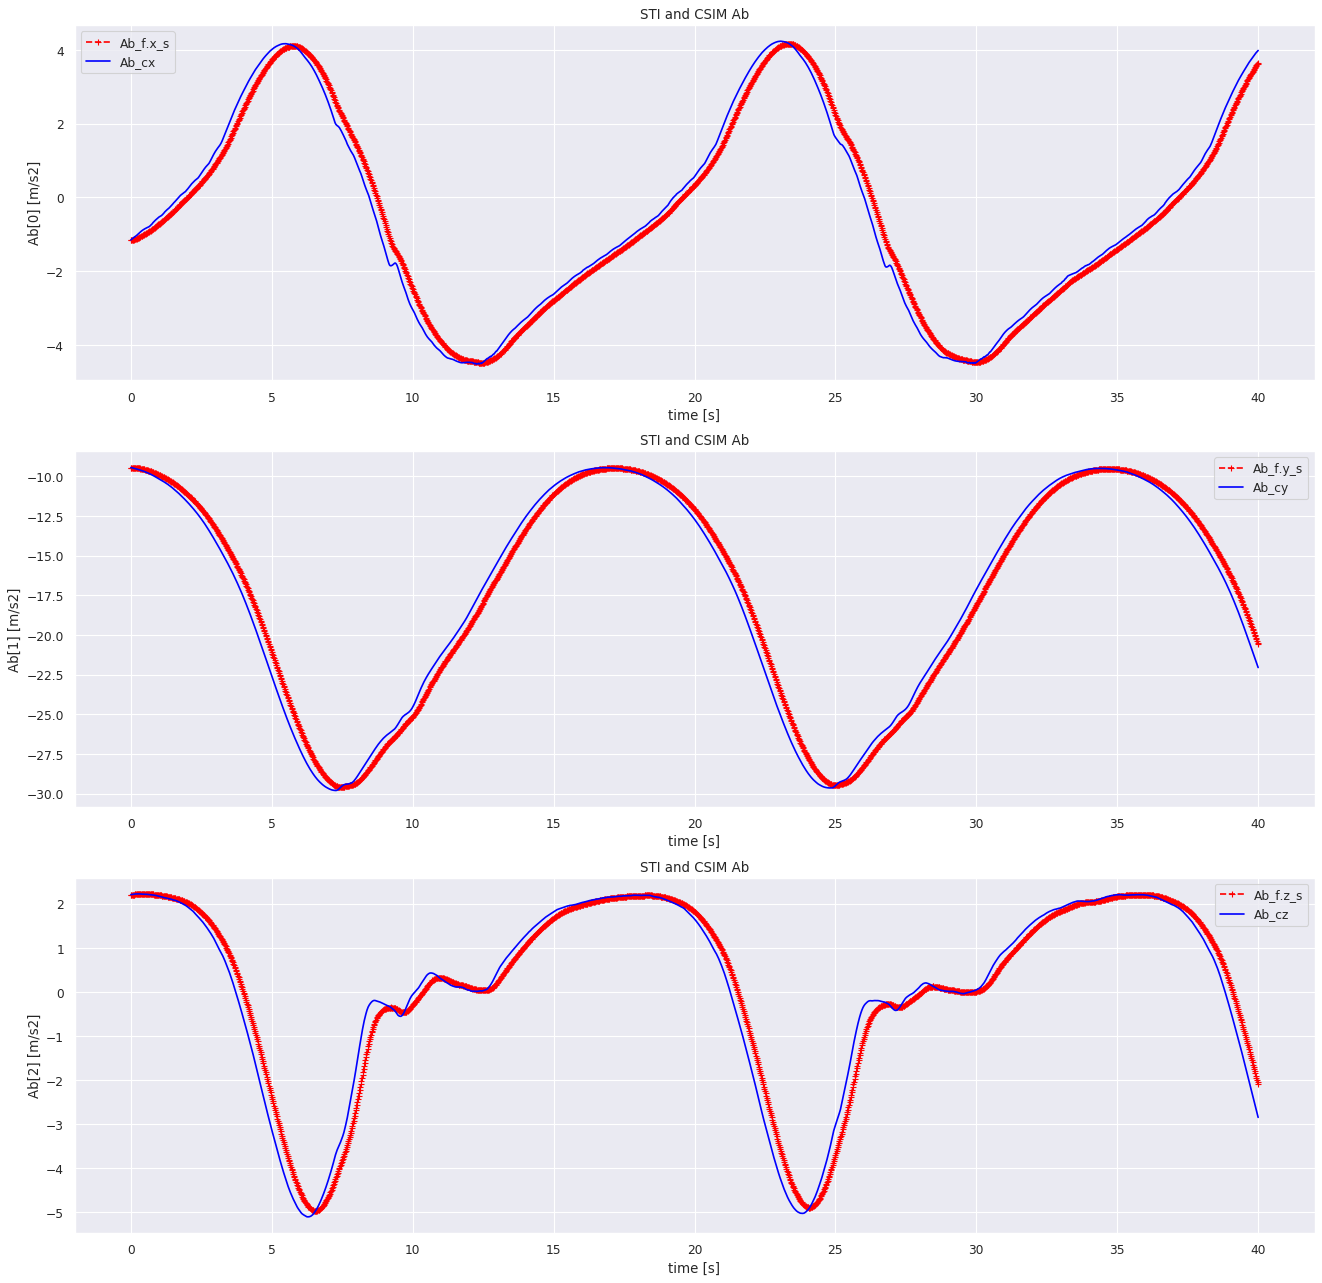

In [75]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
    ax[ii].plot(time_sti,Ab_sti[:,ii],label=Ab_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_c2k,Ab_c2k[:,ii],label='Ab_c'+coords[ii],color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM Ab')
    
    ax[ii].set_ylabel('Ab['+str(ii)+'] [m/s2]')        
        
    plt.legend(loc='best')
plt.show()

## Vb

In [76]:
#Do not have an Vb output from KFAST, I need to make sure STI and CSIM apparent winds match, that confirms states from KFAST were interpreted correctly
Vb_sti_str=np.core.defchararray.add(np.tile('Vb.',3),coords)

Vb_sti=df_sti.loc[:,Vb_sti_str].astype('float').to_numpy()

Vb_sti.shape, Vb_c2k.shape, Vb_c2k[0:3,:]

((2001, 3), (2001, 3), array([[35.25357658, -7.60818173, -6.51676637],
        [35.25746963, -7.63040963, -6.52218185],
        [35.26176147, -7.65257728, -6.52763386]]))

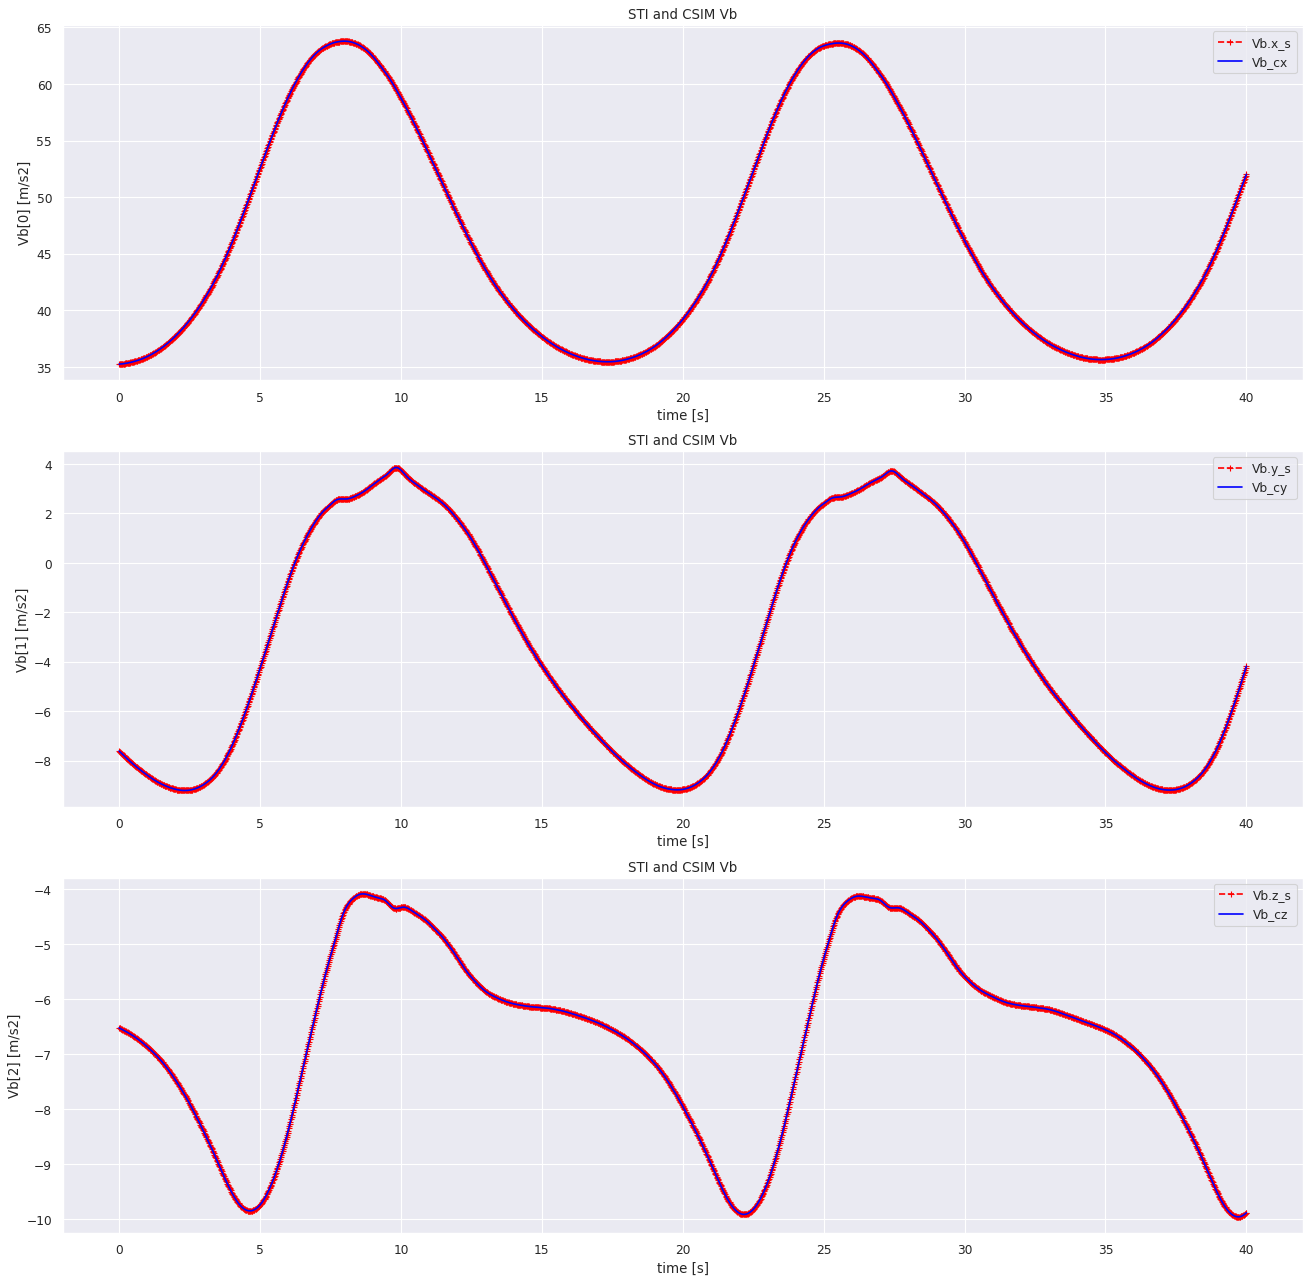

In [77]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
    ax[ii].plot(time_sti,Vb_sti[:,ii],label=Vb_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_c2k,Vb_c2k[:,ii],label='Vb_c'+coords[ii],color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM Vb')
    
    ax[ii].set_ylabel('Vb['+str(ii)+'] [m/s2]')        
        
    plt.legend(loc='best')
plt.show()

## Ag

In [78]:
#Do not have an Ag output from KFC, I need to make sure STI and CSIM apparent winds match, that confirms states from KFAST were interpreted correctly
Ag_sti_str=np.core.defchararray.add(np.tile('Ag.',3),coords)

Ag_sti=df_sti.loc[:,Ag_sti_str].astype('float').to_numpy()

Ag_sti.shape, Ag_c.shape, Ag_c[0:3,:]

((2001, 3), (2001, 3), array([[-3.96150521, -4.51728645,  7.69465405],
        [-3.97345731, -4.49154727,  7.7128905 ],
        [-3.98617615, -4.46561502,  7.73101103]]))

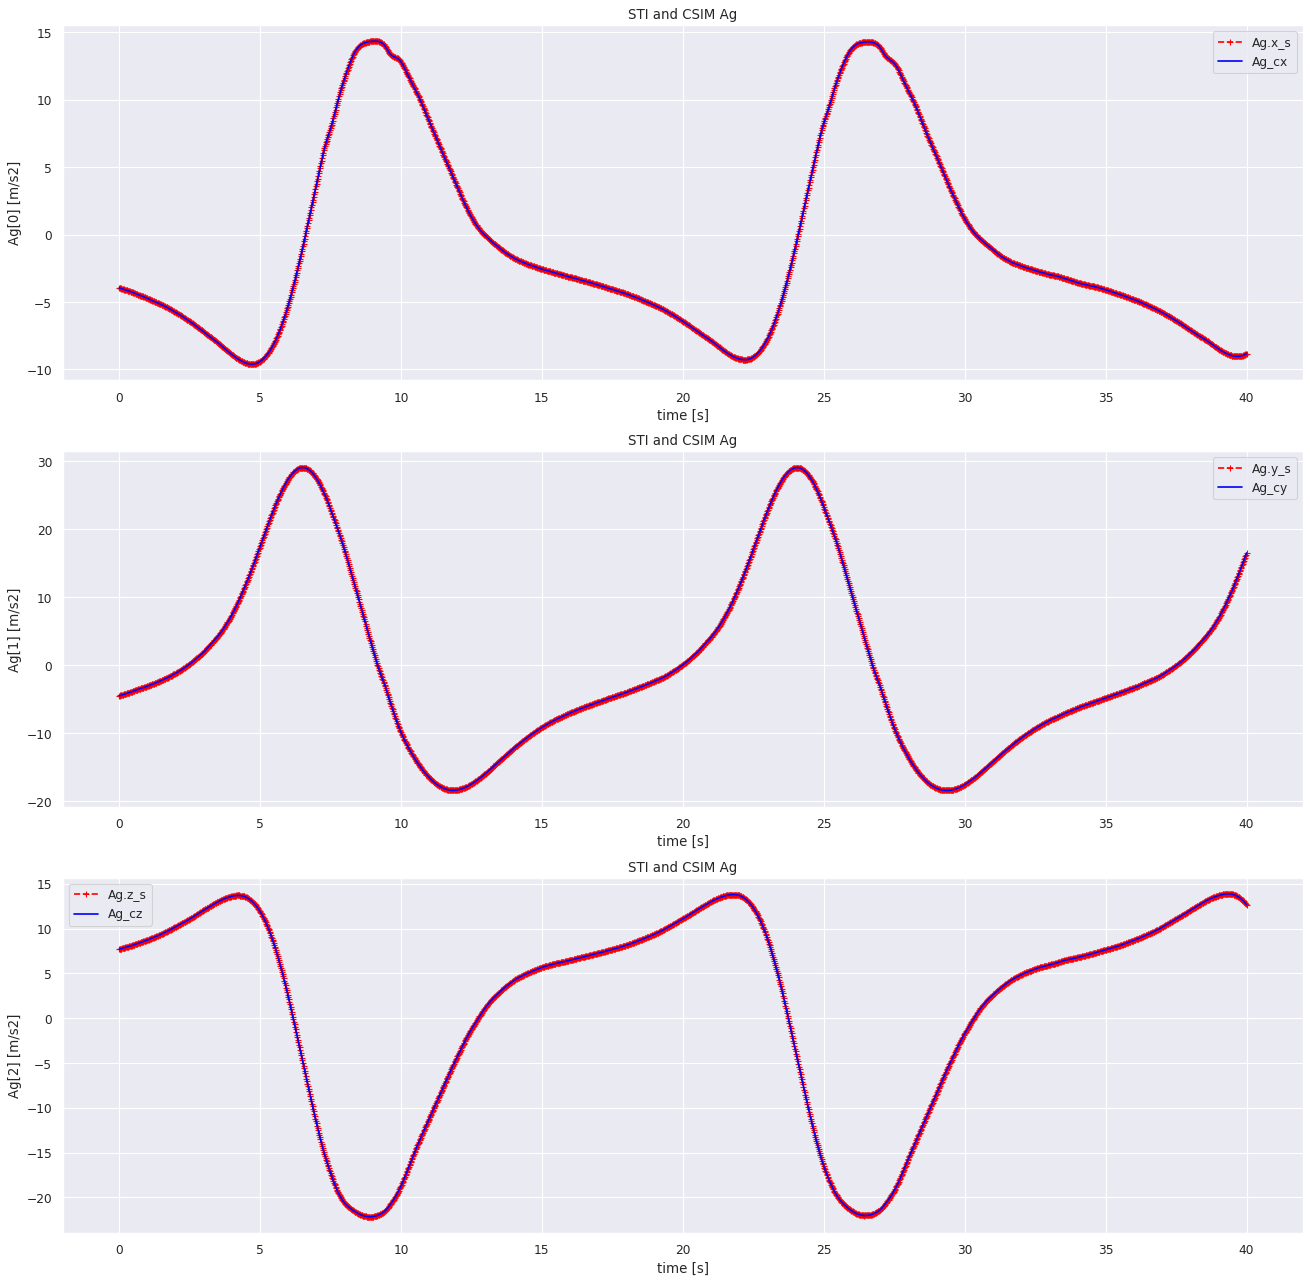

In [79]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
    ax[ii].plot(time_sti,Ag_sti[:,ii],label=Ag_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_c2k,Ag_c[:,ii],label='Ag_c'+coords[ii],color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM Ag')
    
    ax[ii].set_ylabel('Ag['+str(ii)+'] [m/s2]')        
        
    plt.legend(loc='best')
plt.show()

## Vg

In [80]:
#Do not have an Ag output from KFC, I need to make sure STI and CSIM apparent winds match, that confirms states from KFAST were interpreted correctly
Vg_sti_str=np.core.defchararray.add(np.tile('Vg.',3),coords)

Vg_sti=df_sti.loc[:,Vg_sti_str].astype('float').to_numpy()

Vg_cplot=np.vstack([Vg_c['x'],Vg_c['y'],Vg_c['z']]).T
Vg_sti.shape, Vg_cplot.shape, Vg_cplot[0:3,:]

((2001, 3), (2001, 3), array([[ 10.51830189, -33.05890124, -11.81700929],
        [ 10.43895442, -33.14898833, -11.66293167],
        [ 10.35936055, -33.23856236, -11.50849193]]))

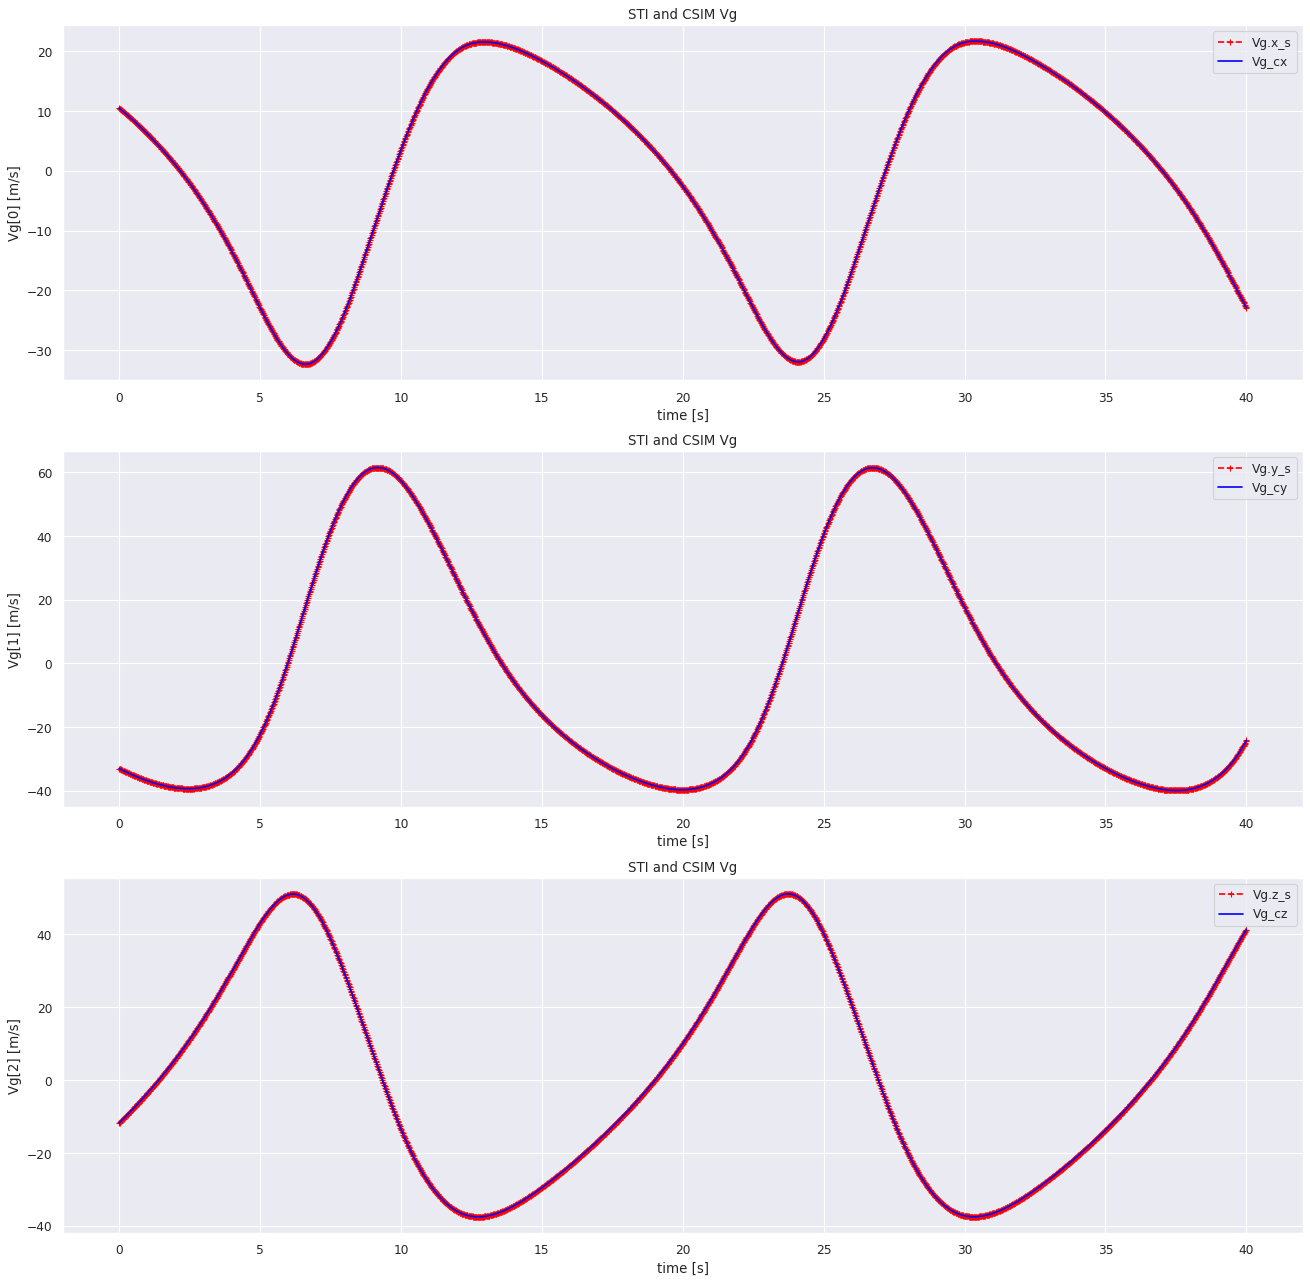

In [81]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
    ax[ii].plot(time_sti,Vg_sti[:,ii],label=Vg_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_c2k,Vg_cplot[:,ii],label='Vg_c'+coords[ii],color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM Vg')
    
    ax[ii].set_ylabel('Vg['+str(ii)+'] [m/s]')        
        
    plt.legend(loc='best')
plt.show()

## Xg

In [82]:
#Do not have an Xg output from KFC, I need to make sure STI and CSIM apparent winds match, that confirms states from KFAST were interpreted correctly
Xg_sti_str=np.core.defchararray.add(np.tile('Xg.',3),coords)

Xg_sti=df_sti.loc[:,Xg_sti_str].astype('float').to_numpy()

Xg_cplot=np.vstack([Xg_c['x'],Xg_c['y'],Xg_c['z']]).T

Xg_sti.shape, Xg_cplot.shape, Xg_cplot[0:3,:]

((2001, 3), (2001, 3), array([[-299.6791918 ,   17.53376344, -313.76101989],
        [-299.46961884,   16.87168369, -313.9958199 ],
        [-299.26163526,   16.20780732, -314.22753474]]))

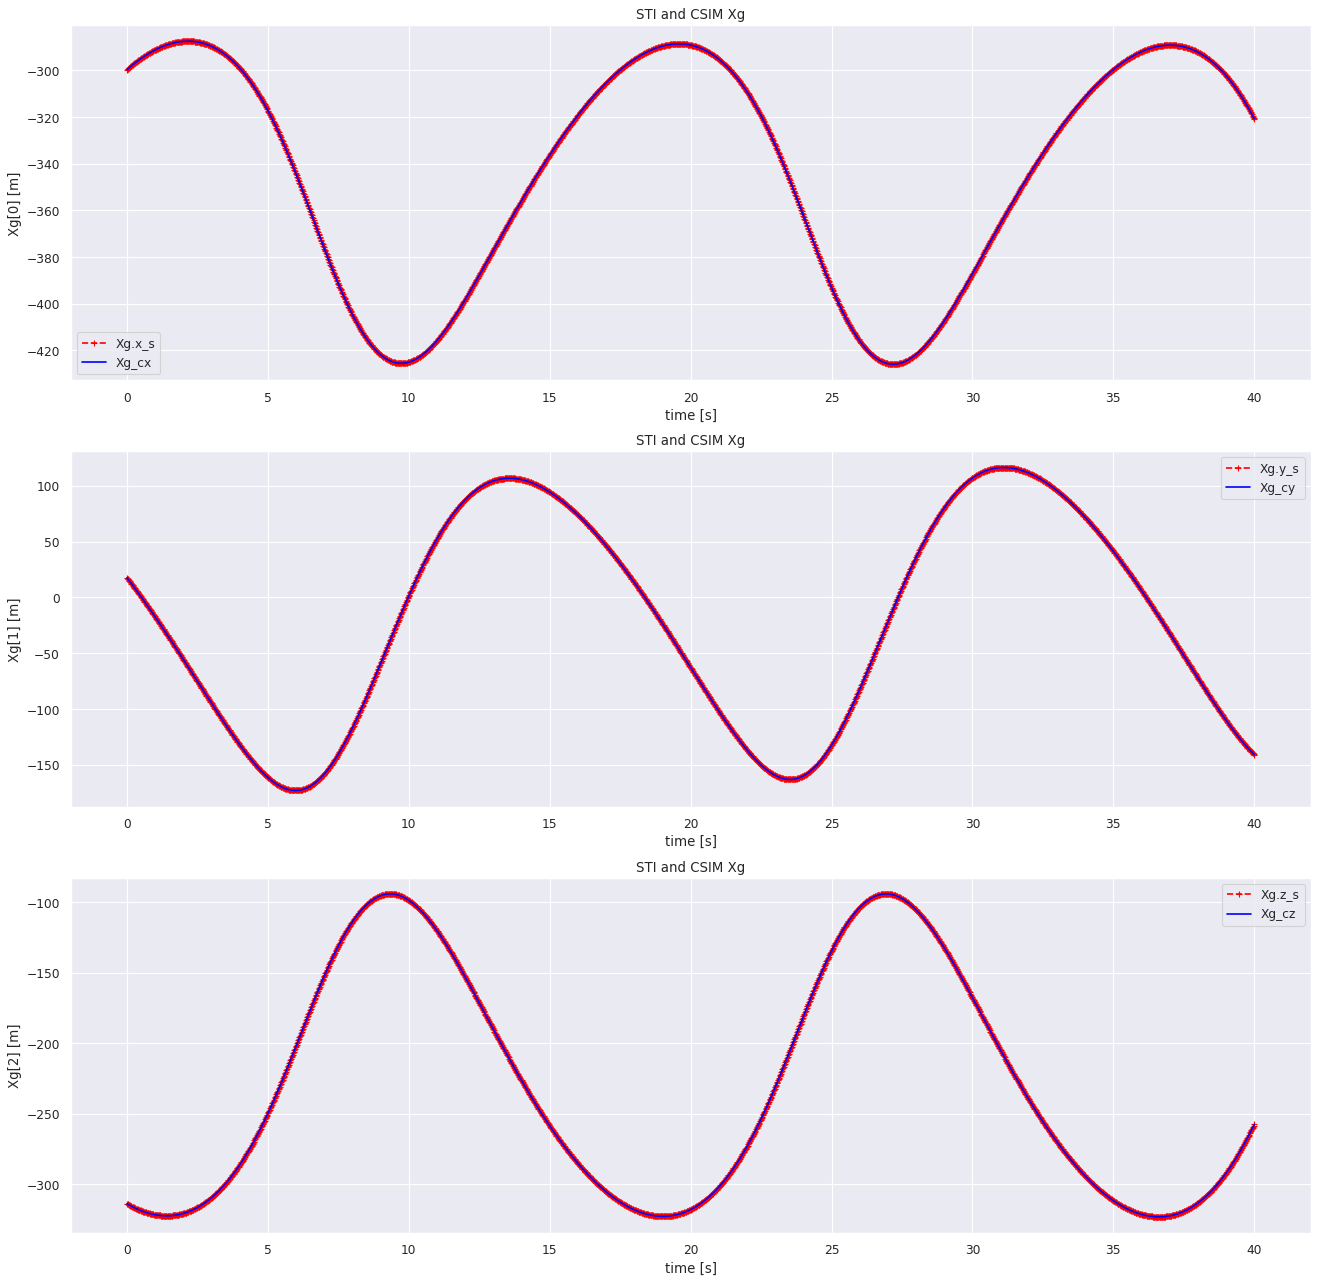

In [83]:
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*3

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,3):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    
    ax[ii].plot(time_sti,Xg_sti[:,ii],label=Xg_sti_str[ii]+'_s',color='red',linestyle='--',marker='+')
    ax[ii].plot(time_c2k,Xg_cplot[:,ii],label='Xg_c'+coords[ii],color='blue')
        
    ax[ii].set_xlabel('time [s]')
    ax[ii].set_title('STI and CSIM Xg')
    
    ax[ii].set_ylabel('Xg['+str(ii)+'] [m]')        
        
    plt.legend(loc='best')
plt.show()

## acc_norm

In [89]:
#Let us also get acc_norm; the only one available is acc_norm_f and from tel3 it is at twice the frequency
acc_norm_f_c=tel3['state_est']['acc_norm_f'][tel3_idx0:]
#Ab_c2k=np.array(Ab_c.tolist(),dtype='float')
acc_norm_f_c.shape 
#So decimate it by simple interpolation for now:
acc_norm_f_c=np.interp(time_c2k, tel3['time'][tel3_idx0:], acc_norm_f_c)
acc_norm_f_c.shape, acc_norm_f_c[100:110]

((2001, 1), array([[6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387]]))

In [85]:
#Filtered acc_norm_f:
STI_acc_norm_f_str='acc_norm_f'
acc_norm_f_STI=df_sti.loc[:,STI_acc_norm_f_str].to_numpy()
#Ag_normf_STI.describe()
acc_norm_f_STI.shape,acc_norm_f_STI[0:10],acc_norm_f_c[0:10]

((2001,), array([9.762536, 9.762998, 9.763908, 9.76524 , 9.766937, 9.769032,
        9.771562, 9.774509, 9.777809, 9.781415]), array([[6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387],
        [6.86589387]]))

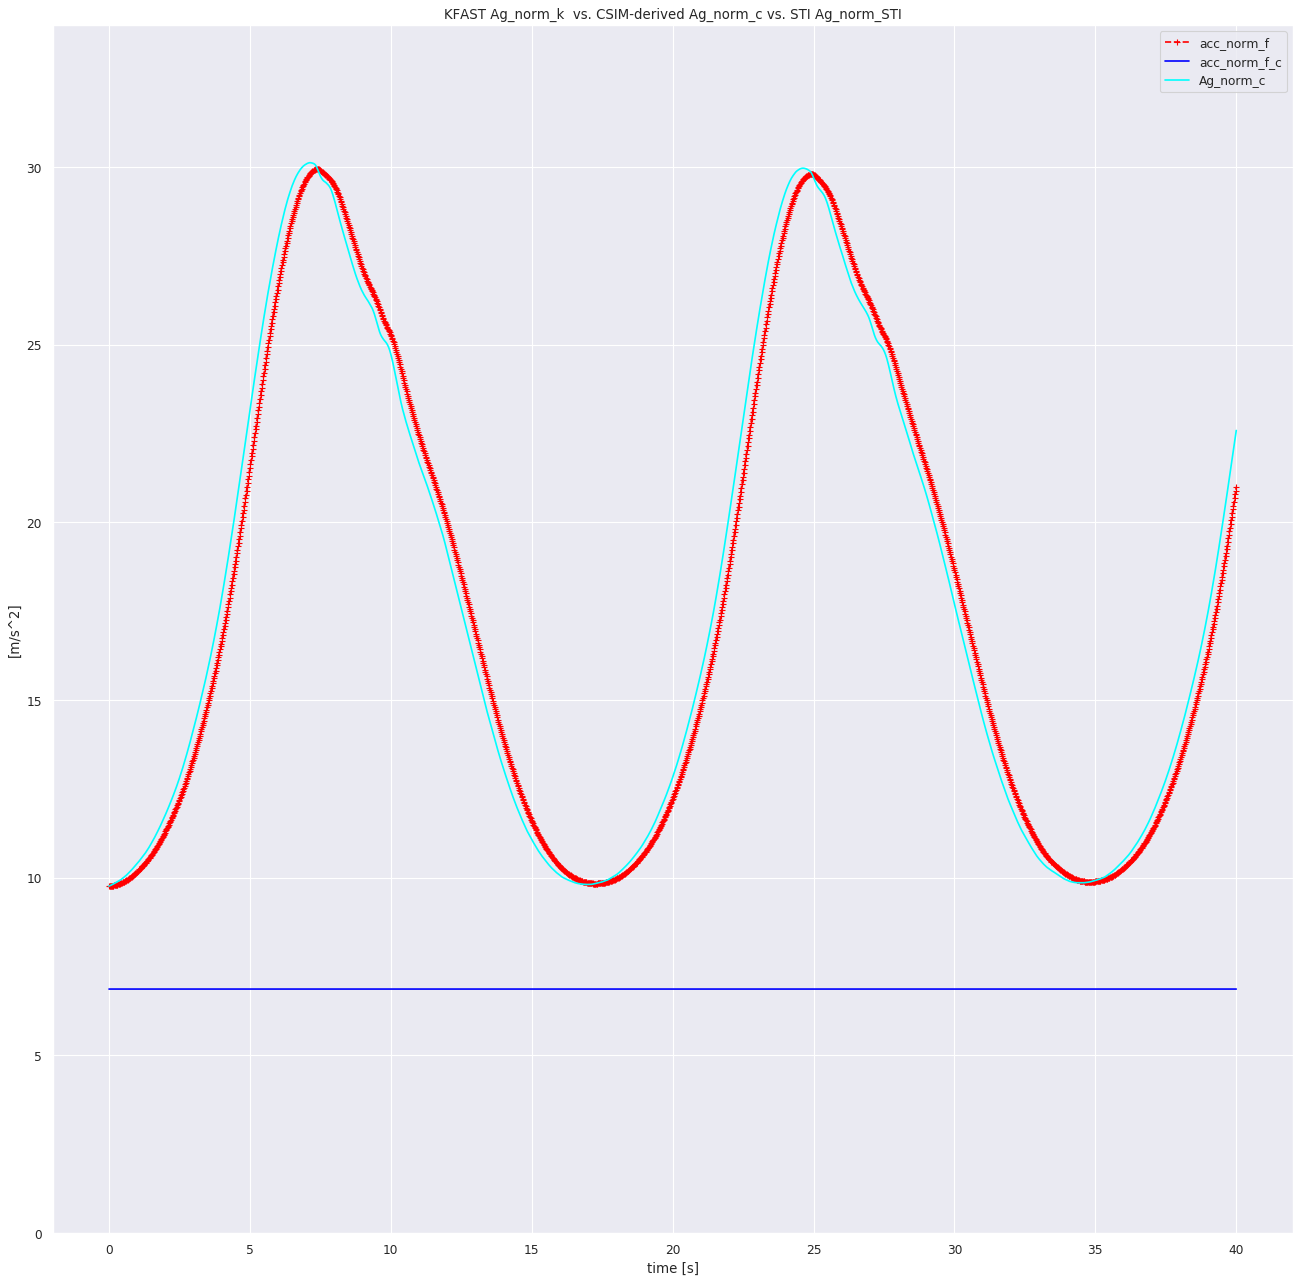

In [86]:
#Plot  filtered  acc_norm_f from STI
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*2

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
    
ax.plot(time_sti,acc_norm_f_STI,label=STI_acc_norm_f_str,color='red',linestyle='--',marker='+')
ax.plot(time_c2k,acc_norm_f_c,label='acc_norm_f_c',color='blue')
ax.plot(time_c2k,Ag_norm_c,label='Ag_norm_c',color='cyan')

ax.set_xlabel('time [s]')
ax.set_ylabel('[m/s^2]')
ax.set_ylim(0,34 )
ax.set_title('KFAST Ag_norm_k  vs. CSIM-derived Ag_norm_c vs. STI Ag_norm_STI')
plt.legend(loc='best')

## I am not sure what CSIM's accnorm_f is, it must be something different. At this point, I think everything jives fine with states